# Analysing Spatial Data

## Introduction

The analysis of spatial is peformed :
   * to make inferences and conclusions about a hypothesized data generating process 
   * to use an estimated process to predict values at location for which observations are unavailable
   
   Data may be partitioned into: <p>&nbsp;</p> $$ data = smooth + rough $$ <p>&nbsp;</p>
   
   Spatial Data may be partitioned into: <p>&nbsp;</p> $$ data = smooth + spatial smooth + rough $$ <p>&nbsp;</p>

## Interpolation and Geostatistics

### Introduction

Geostatistical data are often limited in number of observation
locations. The pattern of observation locations is usually not of primary interest and has constraints to being ‘representative’ or random sampling varieties.

#### Interests are:
 * measure something that was not measured (estimated values excedence probability or estimates of aggregates over given regions)
 * Inference of the process that generated the data
 * Monitoring network optimization
 * Dill hole data
 * Interpolation of environmental variables from sample or monitorin network data
 * Interpolation of physical or chemical variables from sample data
 * Estimation of spatial averages from continuous, spatially correlated data
 
 Geostatistical analysis involves estimation and modelling of spatial correlation (covariance or semivariance), and evaluating whether simplifying assumption such as stationarity  can be justified or need refinement
 
 It can include condition simulation and model-based inference
 
### Exploratory Data Analysis

* plotting of maps with measured variable

In [1]:
library(lattice)
library(sp)
library(gstat)

In [2]:
setwd("/home/erick/spatial-data-with-r")
#Sys.setlocale(locale="C")

* Loading the data in

In [3]:
data(meuse)
class(meuse)
coordinates(meuse) <- c("x", "y")
class(meuse)

[1] "data.frame"

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

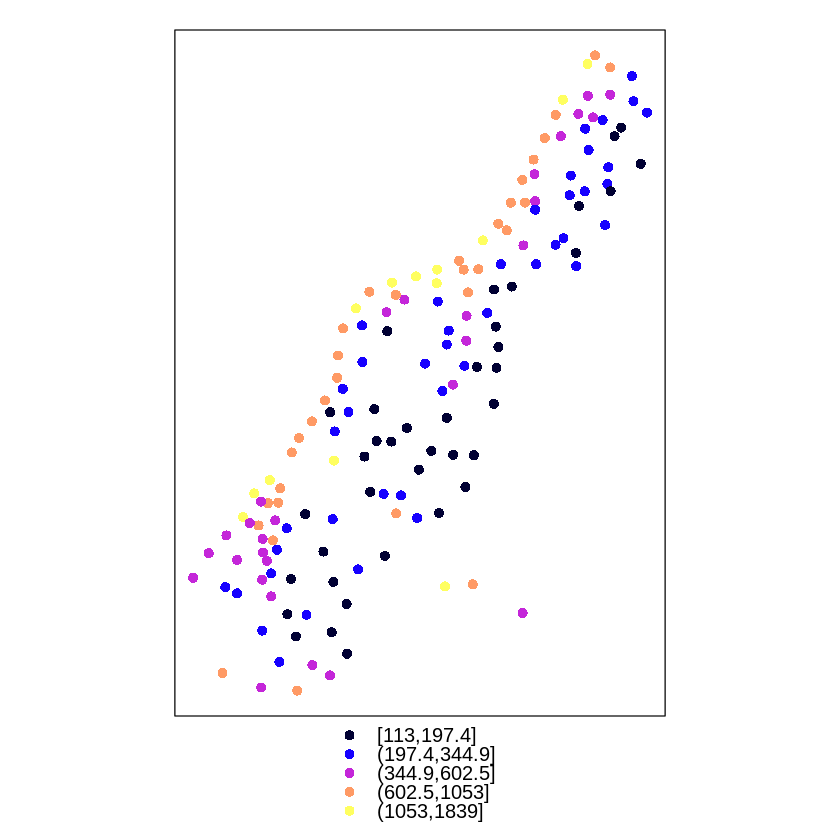

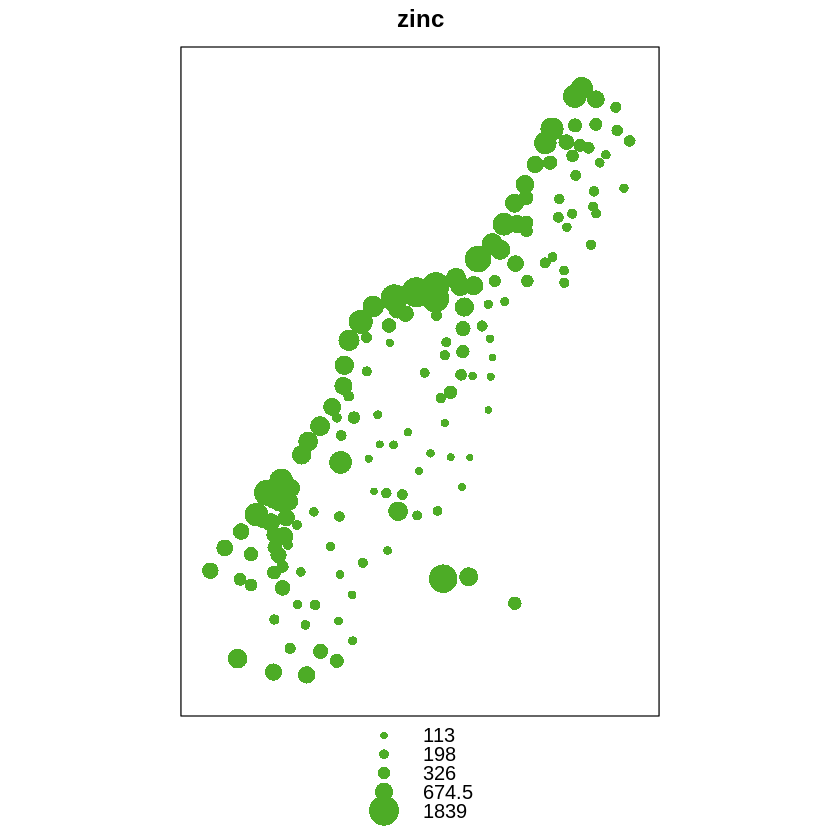

In [4]:
spplot(meuse, "zinc", do.log = T)
bubble(meuse, "zinc", do.log = T, key.space = "bottom")

* The evident structure here is that zinc concentration is larger close to the river Meuse banks.Therefore, we can test the relation between top soil zinc concentration and distance to the river

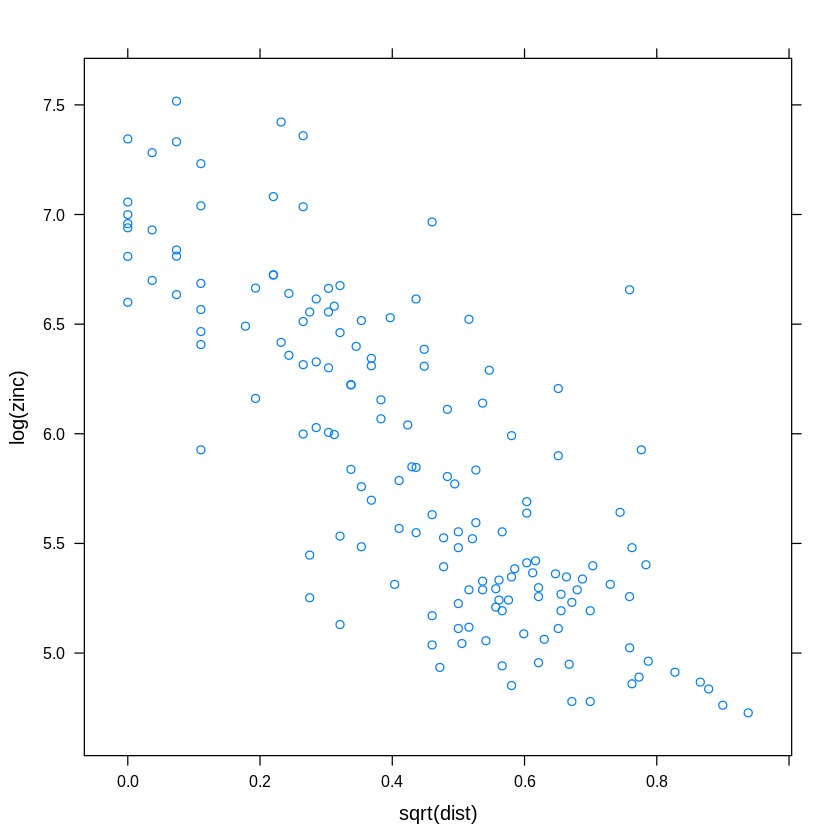

In [6]:
# log of the zinc concentration by the square-root of the distance
xyplot(log(zinc) ~ sqrt(dist), as.data.frame(meuse))

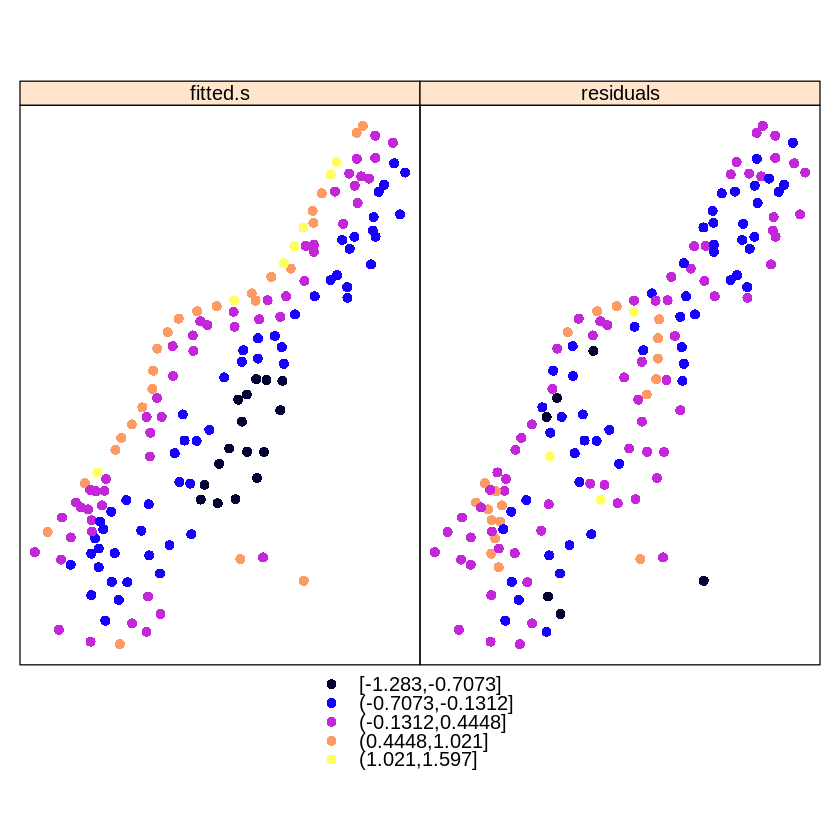

In [14]:
# Fitting a linear model
zn.lm <- lm(log(zinc) ~ sqrt(dist), meuse)
meuse$fitted.s <- predict(zn.lm, meuse) - mean(predict(zn.lm, meuse))

# Plotting both the fitted data and the residuals
meuse$residuals <- residuals(zn.lm)
spplot(meuse, c("fitted.s", "residuals"))

* This figure reveals that although the trend removes a large part of the variability, the residuals do not appear to behave as spatially unstructured

## Non-Geostatistical Interpolation Methods

often interpolation is performed on a regular grid for that reason we will use meuse.grid data

### Inverse Distance Weighted Interpolation

Inverserd distance-based weighted interpolation (IDW) computes a weighted average

<p>&nbsp;</p>
\begin{split}
\hat Z_{(s_0)} & = \frac{\sum_{i=1}^{n} w{(s_i)}Z{s_i}}{\sum_{i=1}^{n} w{(s_i)}} \\
\end{split}
<p>&nbsp;</p>


Weights for observation are computed according to their distance to the interpolation location:

<p>&nbsp;</p>
\begin{split}
\ w_{(s_i)} & = \|s_{i}-s_{0}  \|^{-p}
\end{split}


In [5]:
data(meuse.grid)
class(meuse.grid)
coordinates(meuse.grid) <- c("x", "y")
class(meuse.grid)
meuse.grid <- as(meuse.grid, "SpatialPixelsDataFrame")

[1] "data.frame"

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

In [6]:
library(gstat)
idw.out <- idw(zinc ~ 1, meuse, meuse.grid, idp = 2.5)
as.data.frame(idw.out)[1:5, ]

[inverse distance weighted interpolation]


,x,y,var1.pred,var1.var
,<dbl>,<dbl>,<dbl>,<dbl>
1,181180,333740,701.9621,NA
2,181140,333700,799.9616,NA
3,181180,333700,723.5780,NA
4,181220,333700,655.3131,NA
5,181100,333660,942.0218,NA


* Inverse distance interpolation results usually in maps that are very similar to kriged maps when a variogram with no or a small nugget is used
* Differetnly to kriging, only consideres distances to the prediction location and ignores the spatial configuration of observations. It is not suitable if locations are strongly clustered
* Another difference is that weights are always between 0 and 1

### Linear Regression

Spatial prediction can be done using simple linear model with **lm** command or using the **krige** function even though no krigging is performed as no variogram is specified

In [17]:
# Linear model using lm
zn.lm <- lm(log(zinc) ~ sqrt(dist), meuse)
meuse.grid$pred <- predict(zn.lm, meuse.grid)
meuse.grid$se.fit <- predict(zn.lm, meuse.grid, se.fit = TRUE)$se.fit
summary(meuse.grid)

Object of class SpatialPixelsDataFrame
Coordinates:
     min    max
x 178440 181560
y 329600 333760
Is projected: NA 
proj4string : [NA]
Number of points: 3103
Grid attributes:
  cellcentre.offset cellsize cells.dim
x            178460       40        78
y            329620       40       104
Data attributes:
     part.a           part.b            dist        soil     ffreq   
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000   1:1665   1: 779  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.1193   2:1084   2:1335  
 Median :0.0000   Median :1.0000   Median :0.2715   3: 354   3: 989  
 Mean   :0.3986   Mean   :0.6014   Mean   :0.2971                    
 3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.:0.4402                    
 Max.   :1.0000   Max.   :1.0000   Max.   :0.9926                    
      pred           se.fit       
 Min.   :4.455   Min.   :0.03496  
 1st Qu.:5.303   1st Qu.:0.03743  
 Median :5.666   Median :0.04448  
 Mean   :5.731   Mean   :0.04865  
 3rd Qu.:6.114   3rd Qu.

In [16]:
# Using krige method
meuse.lm <- krige(log(zinc) ~ sqrt(dist), meuse, meuse.grid)
summary(meuse.lm)

[ordinary or weighted least squares prediction]


Object of class SpatialPixelsDataFrame
Coordinates:
     min    max
x 178440 181560
y 329600 333760
Is projected: NA 
proj4string : [NA]
Number of points: 3103
Grid attributes:
  cellcentre.offset cellsize cells.dim
x            178460       40        78
y            329620       40       104
Data attributes:
   var1.pred        var1.var     
 Min.   :4.455   Min.   :0.1907  
 1st Qu.:5.303   1st Qu.:0.1909  
 Median :5.666   Median :0.1914  
 Mean   :5.731   Mean   :0.1920  
 3rd Qu.:6.114   3rd Qu.:0.1925  
 Max.   :6.994   Max.   :0.1983  

In [18]:
meuse.tr2 <- krige(log(zinc) ~ 1, meuse, meuse.grid, degree = 2)

[ordinary or weighted least squares prediction]


#### Trend surface analysis 

Polynomials of spatial coodinates used as predictors

In [7]:
# highly sensible to oulier observation
lm(log(zinc) ~ I(x^2) + I(y^2) + I(x * y) + x + y, meuse)


Call:
lm(formula = log(zinc) ~ I(x^2) + I(y^2) + I(x * y) + x + y, 
    data = meuse)

Coefficients:
(Intercept)       I(x^2)       I(y^2)     I(x * y)            x            y  
  2.395e+04    8.575e-07    8.467e-07   -1.623e-06    2.279e-01   -2.684e-01  


## Estimating Spatial Correlation: The Variogram


In geostatistics, the spatial correlation is modelled by the variogram instead of correlogram or covariogram. Variogram and semivariogram is often used synonymously.
    The spatial correlation between two observations of $Z(s)$ at $s_1$ and $s_2$ location cannot be estimated if only a single pair is available. To estimate the spatial corelation between a given set of locations, the first assumption to be made is that observeed data is **stationary** (or **intrinsic stationary**). <p>&nbsp;</p> $$ Z_(s) = m + e(s) $$ <p>&nbsp;</p> Therefore, if the mean is constant, then: <p>&nbsp;</p> $$E(Z(s)) = m$$ <p>&nbsp;</p> and a variogram defined as     
    
\begin{split}
γ_{(h)} & = \frac{1}{2}E(Z_{(s)}-Z(s + h))^2 \\
\end{split}
    
<p>&nbsp;</p>

Which means that variance of Z is constant and does not depend on location s, but only on separation distance h.

$$ h = s_i − s_j $$ 

<p>&nbsp;</p>
The second assuption that can be made is *isotropy*, which is direction independence of semivariance, by replacing $h$ by $\|h\|$. Now the variogram can be estimated from $N_h$ samples $z(s_i)$, $(z(s_i+h)$ or a number of distance intervalas $h_j^{~}$.

<p>&nbsp;</p>

\begin{split}
\hatγ_{(h_i)} & = \frac{1}{2N_h}\sum_{i=1}^{N_h} (Z_{(s_i)}-Z(s_i + h))^2 \\
\end{split}

This estimate is called sample variogram.
<p>&nbsp;</p>

If we allow the mean to vary spatially, then spatial association can be modelled as a linear function of $X_j(s)$ as in:
<p>&nbsp;</p>

\begin{split}
Z_{(s)} & = \sum_{j=0}^{p} X_j{(s)}β_j + e(s)\\
\end{split}
<p>&nbsp;</p>
or simply

\begin{split}
Z_{(s)} & = Xβ_j + e(s)\\
\end{split}
<p>&nbsp;</p>

## Exploratory Variogram Analysis

A simple way to inspect the presence of spatial correlation is to make a scatter plot of pairs of $Z(s_i)$ and $Z(s_j)$ according to their separation distance $h_{ij} = \|s_{i}-s_{j}\|$

* Each box in the plot indicate a distance class (0-100, 100-200, ...)
* ~ 1 defines a single constant predictor, which leads to spatially constant mean coefficient

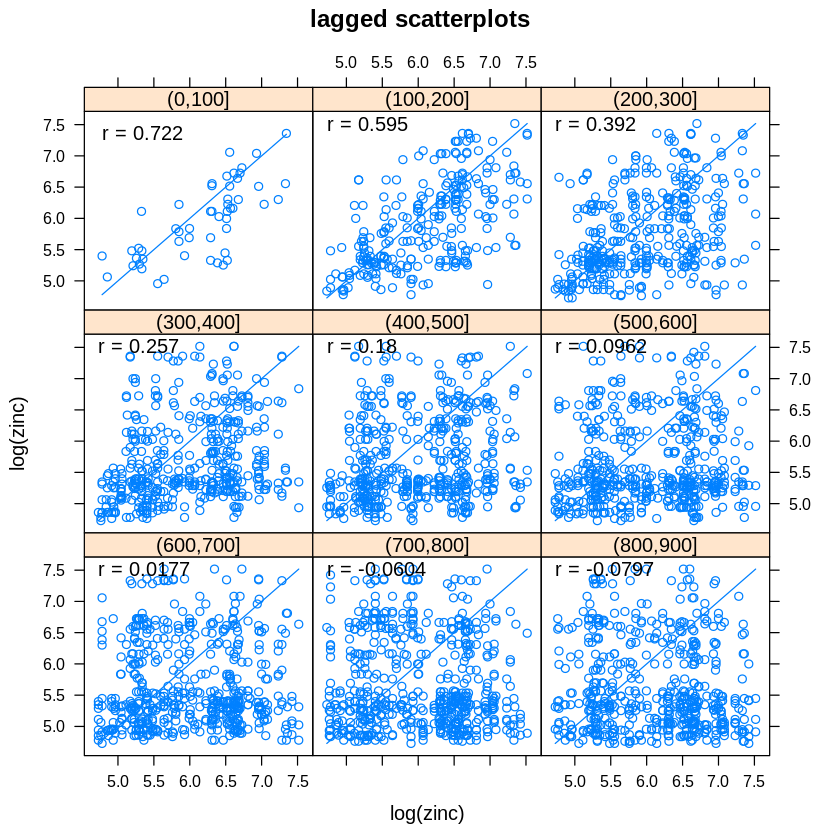

In [19]:
hscat(log(zinc) ~ 1, meuse, (0:9) * 100)

* Instead of plotting as distance classes, we could plot together as a variogram cloud. Each point coordinate is obtained from the pair $(Z_{(s_i)}-Z(s_j))^2$ and their separation distance $h_{ij}$ 

,np,dist,gamma,dir.hor,dir.ver,id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,57,79.29244,0.1234479,0,0,var1
2,299,163.97367,0.2162185,0,0,var1
3,419,267.36483,0.3027859,0,0,var1
4,457,372.73542,0.4121448,0,0,var1
5,547,478.47670,0.4634128,0,0,var1
6,533,585.34058,0.5646933,0,0,var1


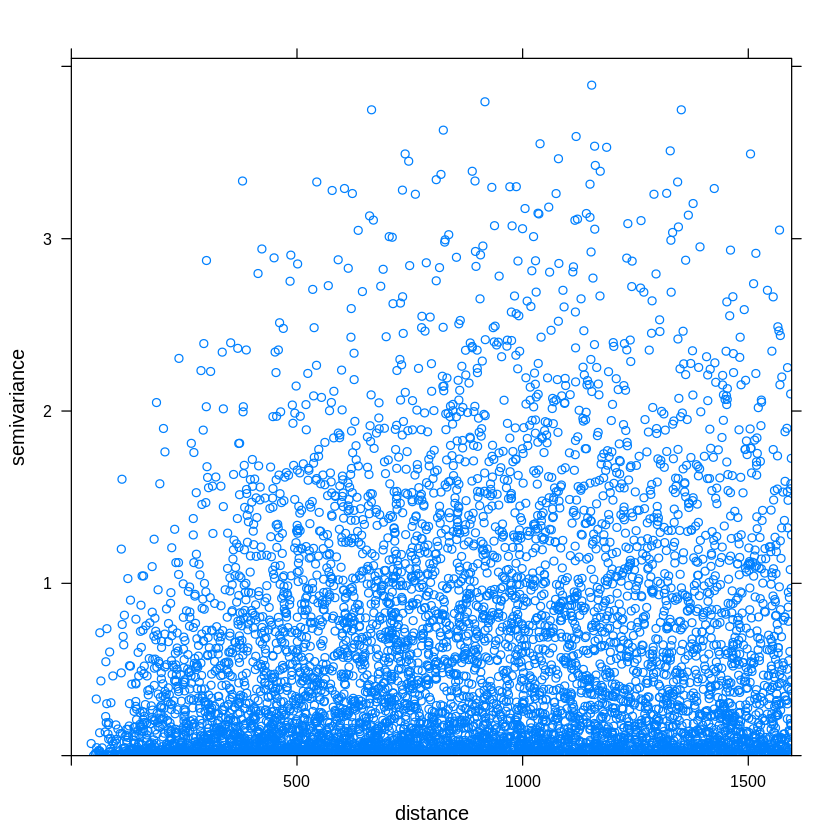

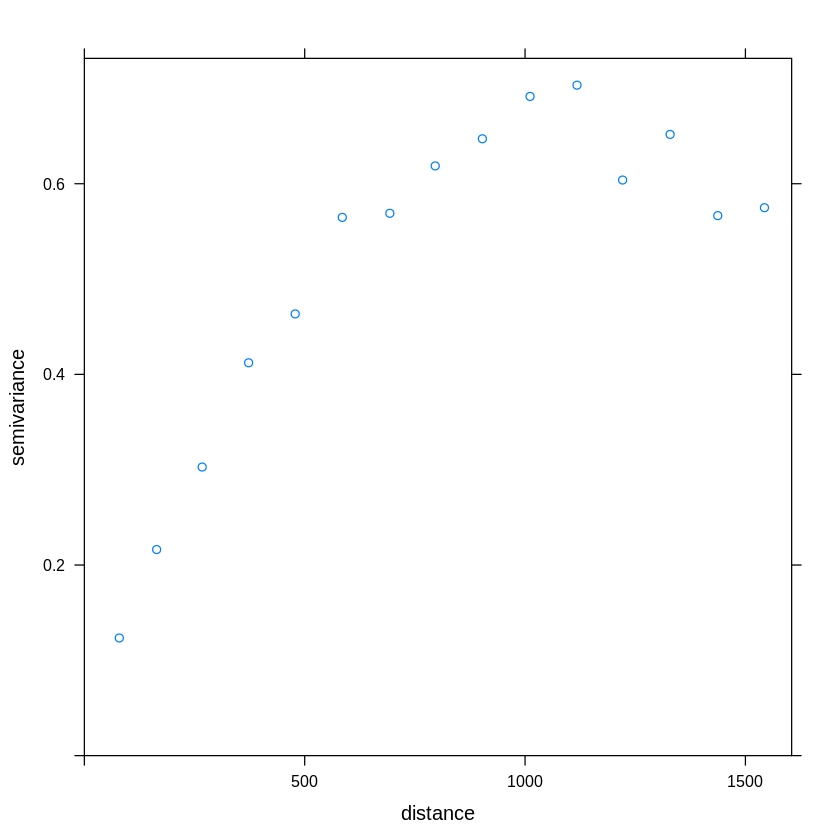

In [25]:
plot(variogram(log(zinc) ~ 1, meuse, cloud = TRUE))
head(variogram(log(zinc) ~ 1, meuse))
plot(variogram(log(zinc) ~ 1, meuse))

* Points in the cloud plot refers to a particular combination (pair of points) and can reveals interesting patterns at the different range values. Some areas in the plot might give indications of non-stationarity or of anisotropy, which can be dealt with by log-transforamtion.
* Outlying observations need to be removed or dealt with more robust approach such as **cressie=TRUE**.

In [44]:
#sel <- plot(variogram(zinc ~ 1, meuse, cloud = TRUE), digitize = TRUE)
#plot(sel, meuse)

### Cutoff, Lag Width, Direction Dependence

* **Angles**: The simplest variogram ignores direction and assumes only the effect of distance. However, we can explore different angles with **alpha** option.
* **Cutoff distance**: maximum distance up to which point pairs are considered and the width of distance interval over which point pairs are averaged in bins. The default value is 1/3 of the largest diagonal of the data.
* **Interval width**: uses the cutoff default values divided by 15. Usually, that is a good values for an *initial* overview. A smaller inteval will result in more information (i.e., $γ(h)$ increases) but also more noise (i.e., $N_h$ decreases).

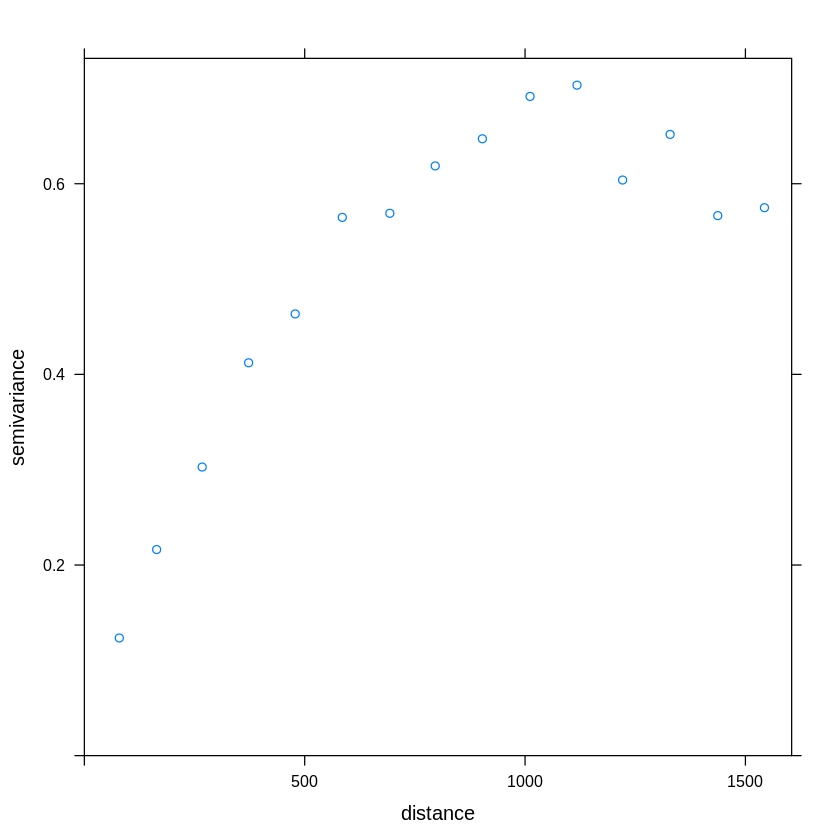

In [47]:
plot(variogram(log(zinc) ~ 1, meuse))

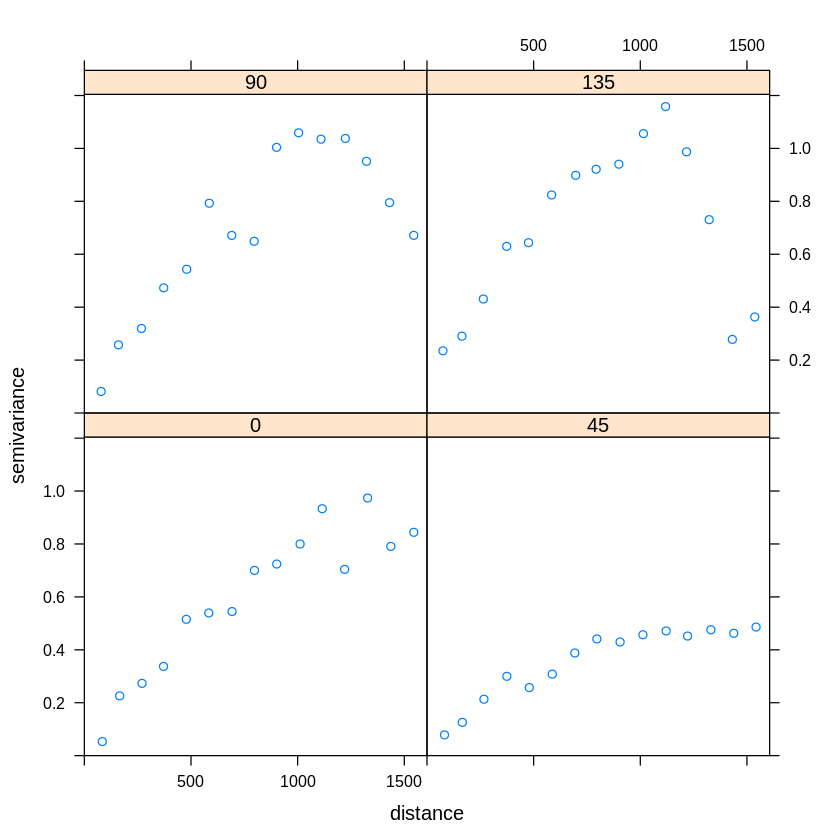

In [48]:
# Different angles
plot(variogram(log(zinc) ~ 1, meuse, alpha = c(0, 45, 90, 135)))

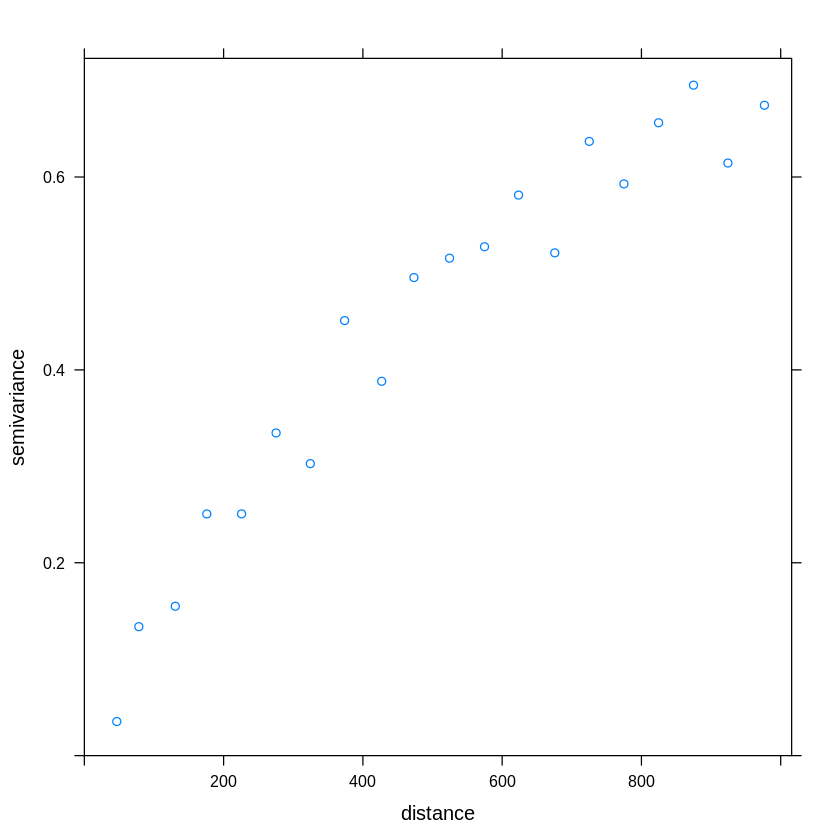

In [49]:
# Different cutoff and width
plot(variogram(log(zinc) ~ 1, meuse, cutoff = 1000, width =50))

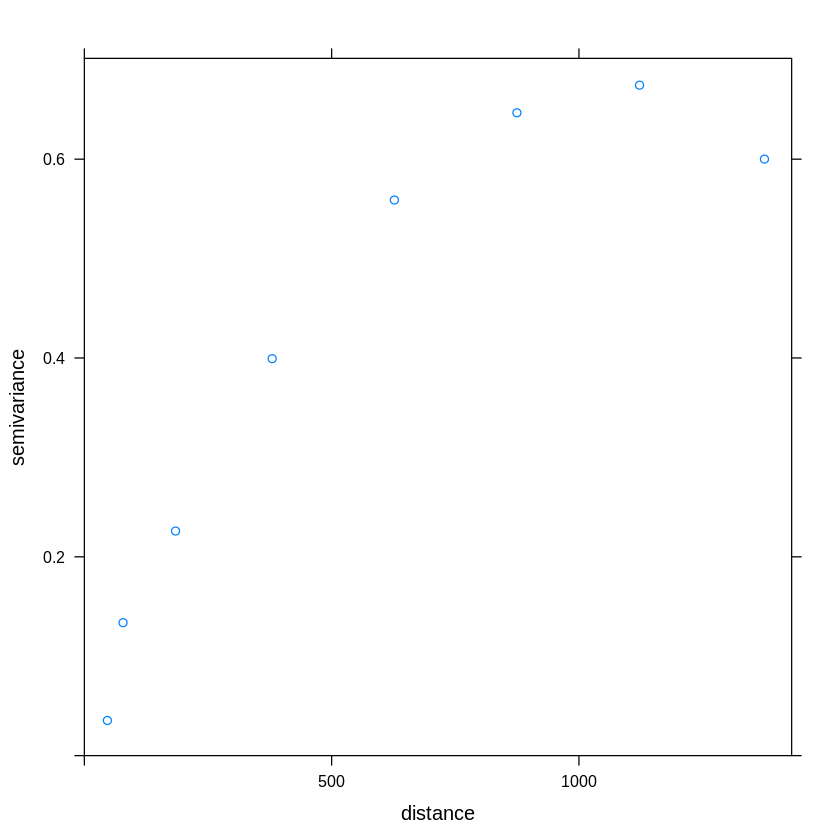

In [51]:
# Smaller distances
plot(variogram(log(zinc) ~ 1, meuse, boundaries = c(0, 50, 100, seq(250, 1500, 250))))

## Variogram Modelling

Variograms are useful for:
   * Spatial predictions (interpolation)
   * Simulation of the observed process based on point observation
 
The traditional way is to fit a parametric model to the sample variogram

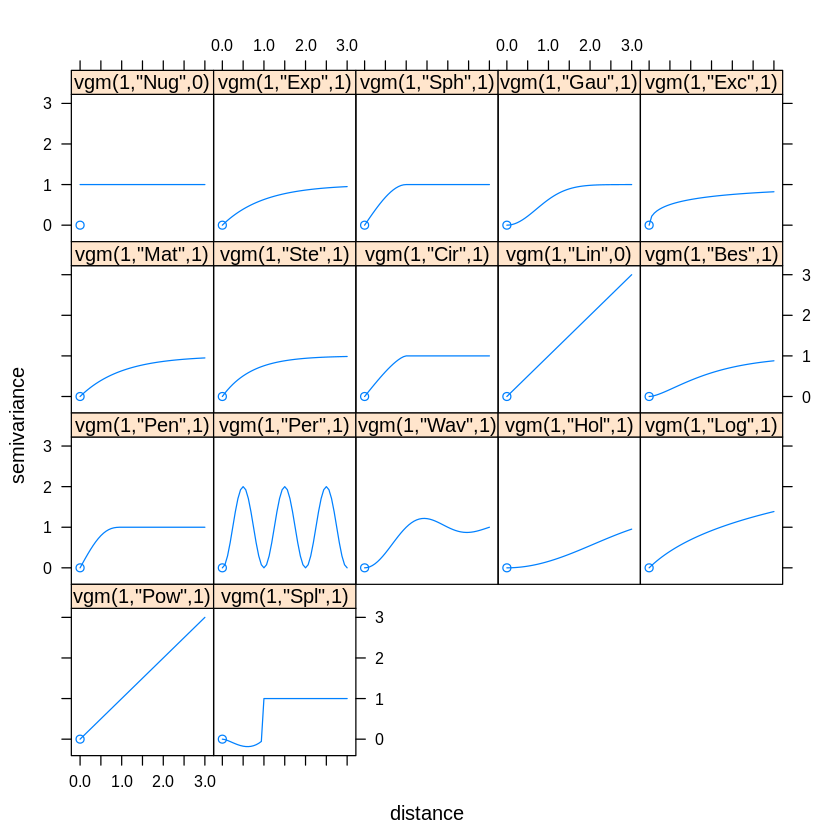

In [53]:
show.vgms()

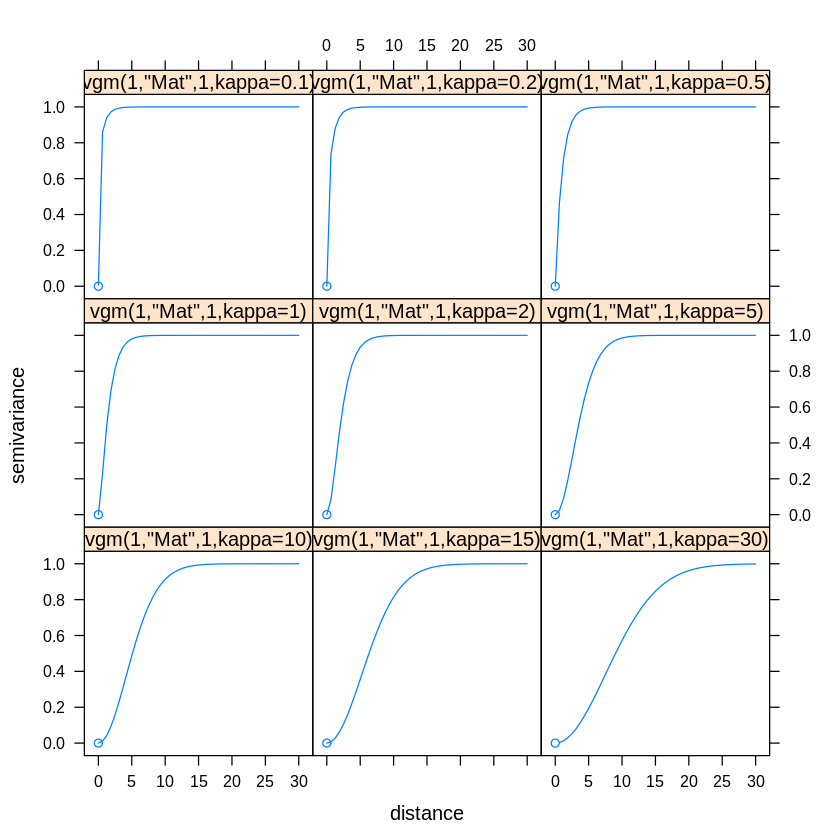

In [57]:
# various kappa values in the Matern Class
suppressWarnings(show.vgms(model = "Mat", kappa.range = c(0.1, 0.2, 0.5, 1, 2, 5, 10, 15, 30), max = 30))

* We can build variogram models by adding parameters (i.e., sill, range, nugget)

In [59]:
# model sph and range 300
vgm(1, "Sph", 300)

model,psill,range,kappa,ang1,ang2,ang3,anis1,anis2
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Sph,1,300,0.5,0,0,0,1,1


In [60]:
# model sph, range 300, and nugget 0.5
vgm(1, "Sph", 300, 0.5)

,model,psill,range,kappa,ang1,ang2,ang3,anis1,anis2
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Nug,0.5,0,0.0,0,0,0,1,1
2,Sph,1.0,300,0.5,0,0,0,1,1


In [65]:
# model type of each component and partial sill and range.
# Nugget variance can be defined in to ways (measurement of error)

v1 <- vgm(1, "Sph", 300, 0.5)
v2 <- vgm(0.8, "Sph", 800, add.to = v1)
v2[,1:3]

,model,psill,range
,<fct>,<dbl>,<dbl>
1,Nug,0.5,0
2,Sph,1.0,300
3,Sph,0.8,800


In [66]:
vgm()

short,long
<fct>,<fct>
Nug,Nug (nugget)
Exp,Exp (exponential)
Sph,Sph (spherical)
Gau,Gau (gaussian)
Exc,Exclass (Exponential class/stable)
Mat,Mat (Matern)
Ste,"Mat (Matern, M. Stein's parameterization)"
Cir,Cir (circular)
Lin,Lin (linear)


* Most used models are: exponential, spherical, Gaussian, Matern, or power models (with ou without nugest).

### Weighted least squares fitting

   - Choose a suitable model (with or without nugget)
   - Choose suitable initial values for partial still, range, and nugget
   - Fit this model using on of the fitting criteria

,model,psill,range
,<fct>,<dbl>,<dbl>
1,Nug,0.05065923,0.0000
2,Sph,0.59060463,896.9976


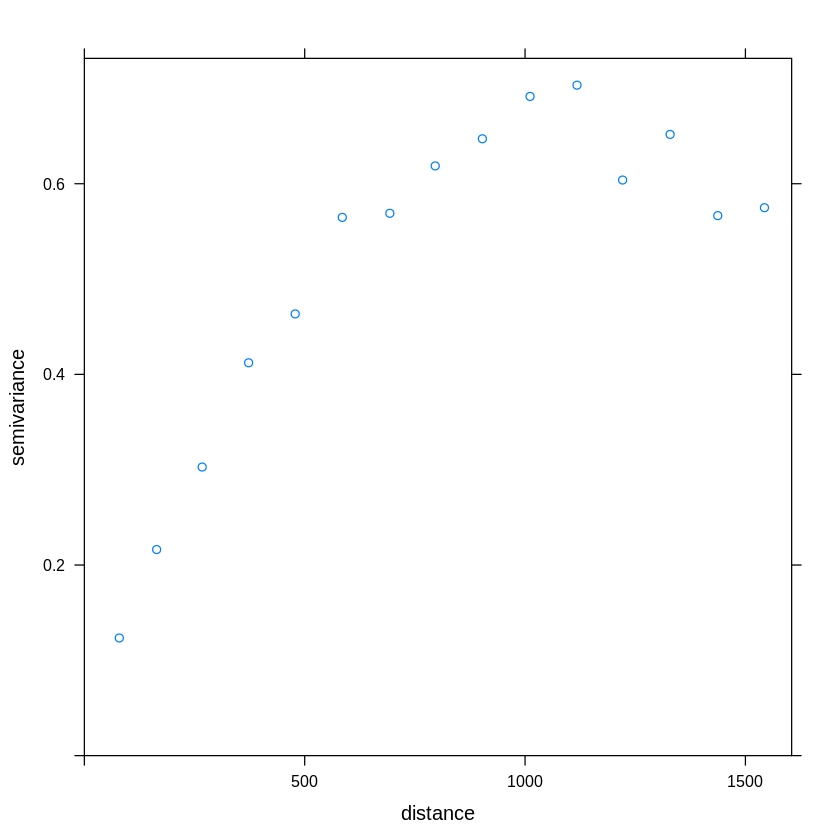

In [10]:
v <- variogram(log(zinc) ~ 1, meuse)
plot(v)
# Selection spherical model, with initial value of 800 for range and 1 for sill
fit.variogram <- fit.variogram(v, vgm(1, "Sph", 800, 1))
fit.variogram[,1:3]

### Fitting method

Weighted sum of square erros is calculated in a way that the $ γ_{(h_i)} $ is minimized.

<p>&nbsp;</p>

\begin{split}
\sum_{i=1}^{p} (γ{(h)}-\hatγ{(h)})^2 \\
\end{split}

The following steps are alternated util convergence is reached:
   - Direct fit over the partial sills
   - non-linear optimizing of the range parameter(s) given the last fit of partial stills.

<p>&nbsp;</p>

#### Different options for the weights $wj$ are given below (option 7 is the default):
<p>&nbsp;</p>

| fit.method  | Weight |
| ------------- | ------------- |
| 1  | \begin{split} Nj\\ \end{split}  |
| 2  | \begin{split} Nj/{γ(hj)}^2\\ \end{split}  |
| 6  | \begin{split} 1\\ \end{split}  |
| 7  | \begin{split} Nj/h_j^2\\ \end{split}  |

<p>&nbsp;</p>




In [74]:
# minimized criterion
attr(fit.variogram, "SSErr")

[1] 9.011194e-06

* An alternative approach to fit variaogram is by visual fitting, the so called eyball fit. Package **geoR** provides a griphical user interface for interactively adajusting the parameters

In [1]:
library(geoR)

--------------------------------------------------------------
 Analysis of Geostatistical Data
 For an Introduction to geoR go to http://www.leg.ufpr.br/geoR
 geoR version 1.8-1 (built on 2020-02-08) is now loaded
--------------------------------------------------------------




variog: computing omnidirectional variogram


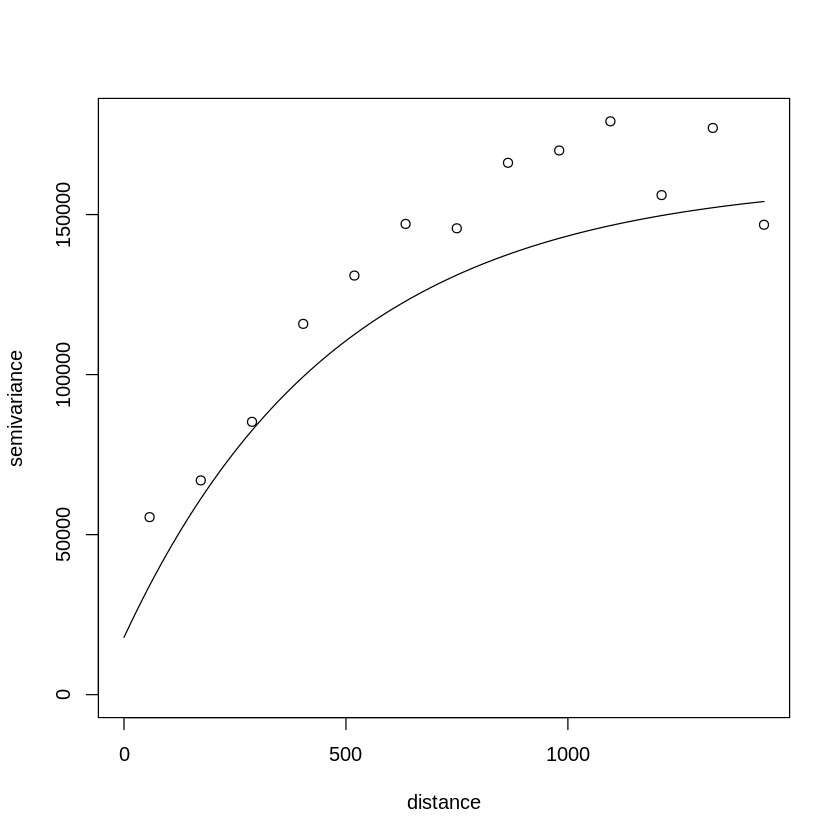

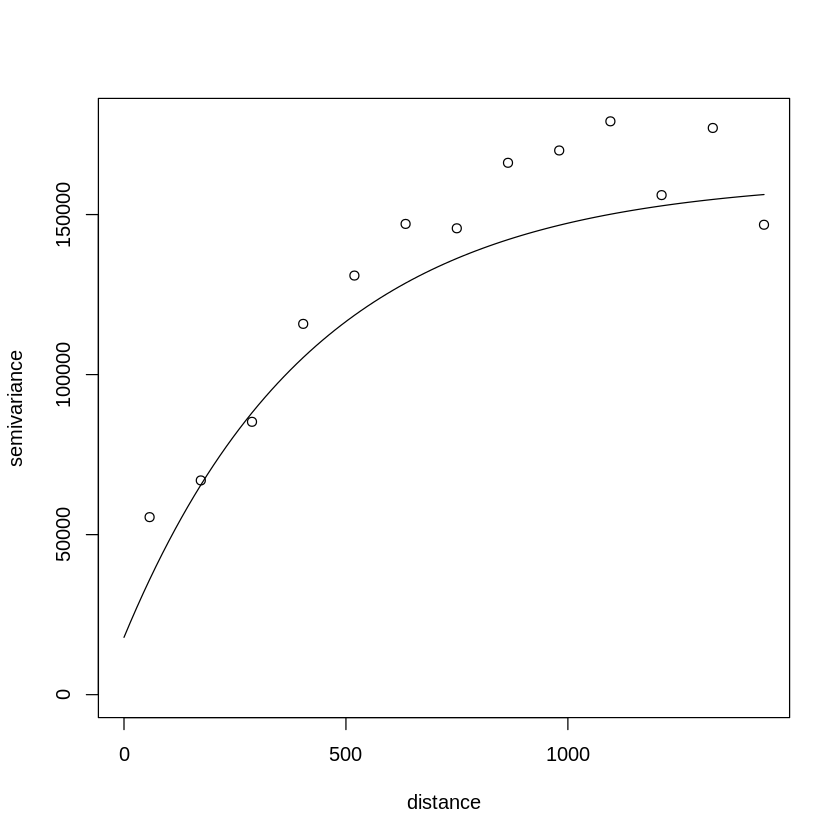

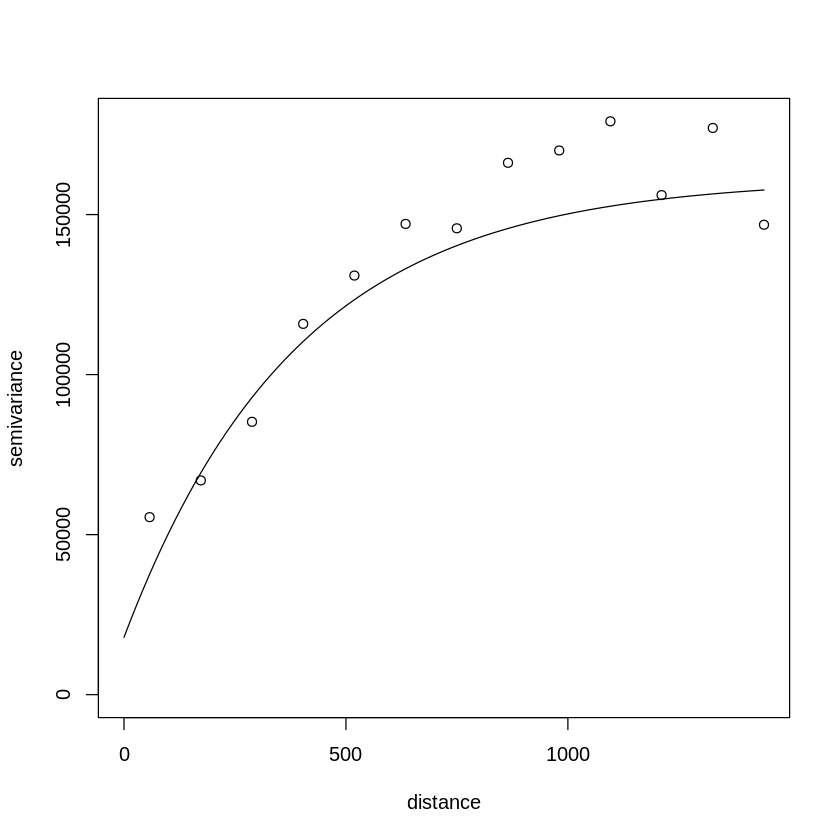

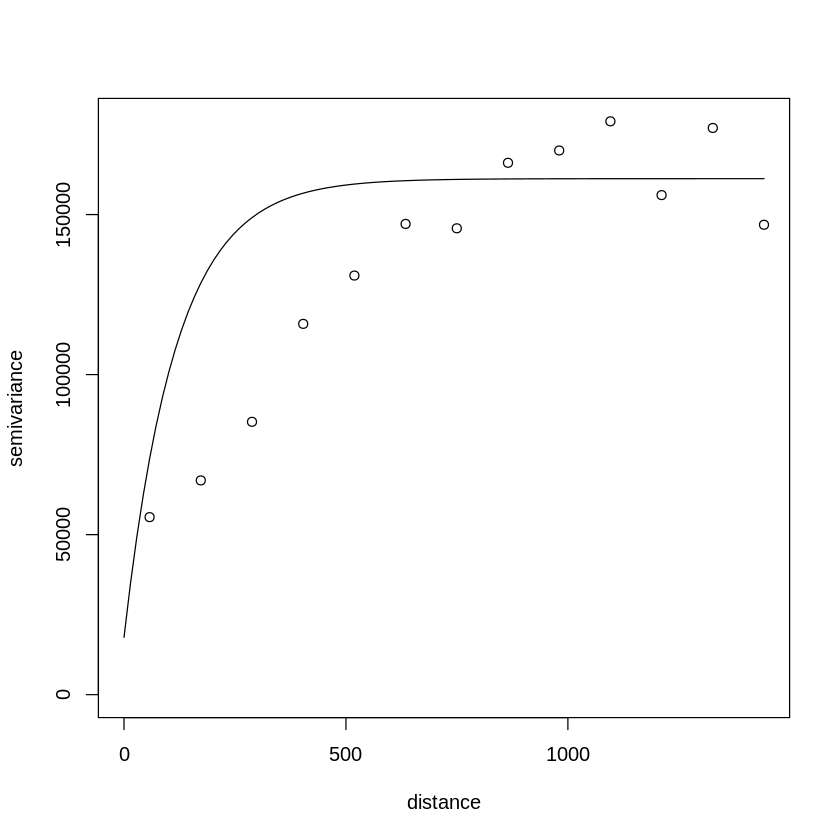

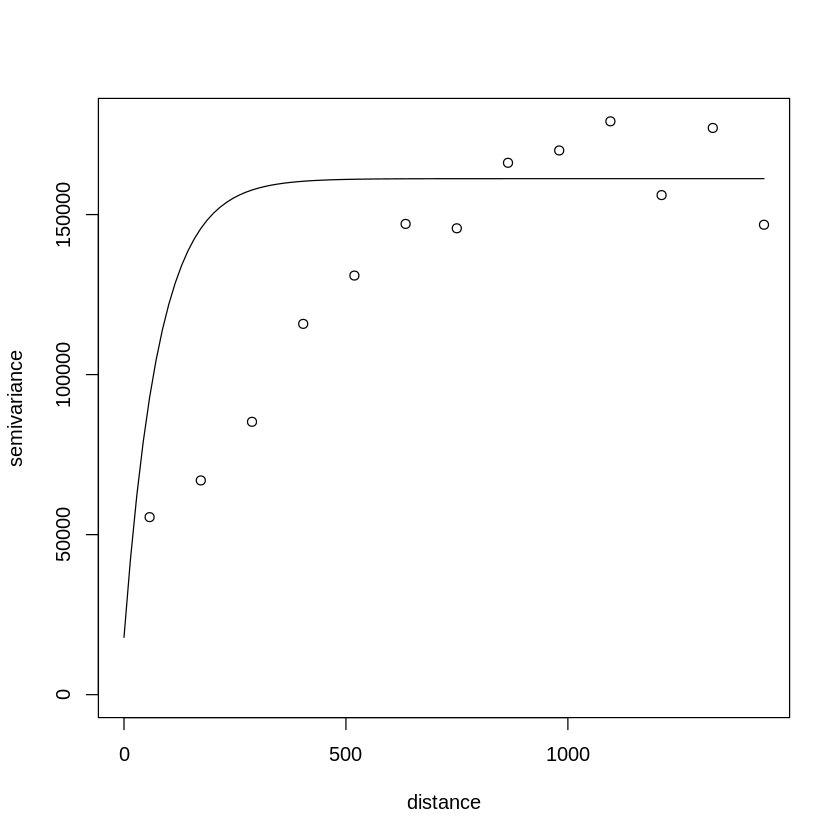

ERROR: Error in v.eye[[1]]: subscript out of bounds


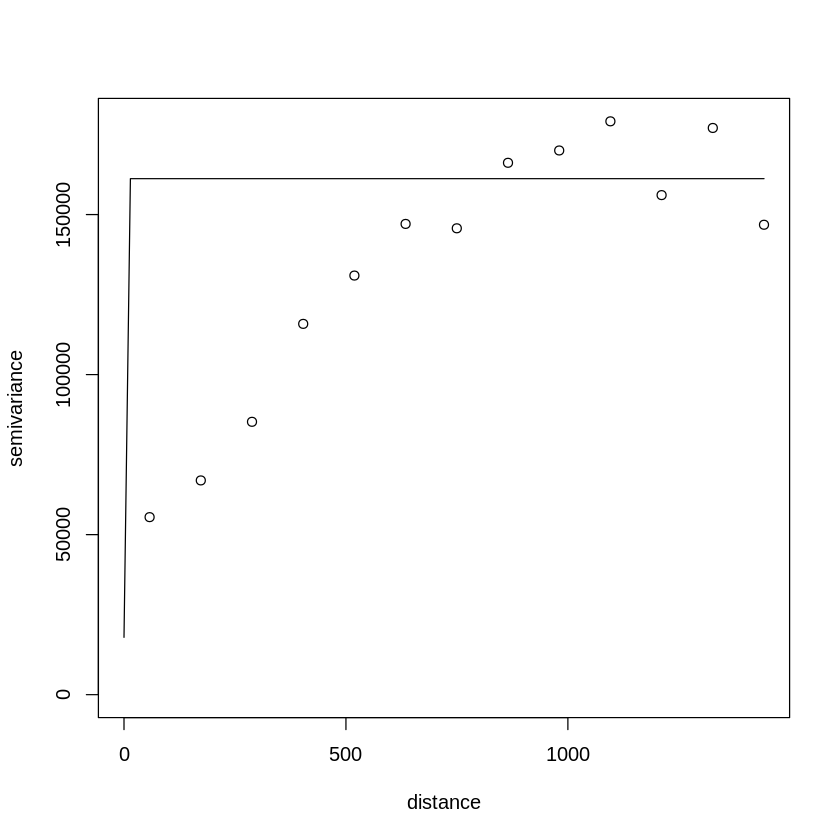

In [8]:
v.eye <- eyefit(variog(as.geodata(meuse["zinc"]), max.dist = 1500))
ve.fit <- as.vgm.variomodel(v.eye[[1]])

* Partial fitting of variagram coefficients can be done with **gstat**. Suppose we know for some reason that partial sill for the nugget model is 0.06, and we want to fit the remaining parameters

In [12]:
fit2 <- fit.variogram(v, vgm(1, "Sph", 800, 0.06), fit.sills = c(FALSE,TRUE))
fit2[,1:3]

,model,psill,range
,<fct>,<dbl>,<dbl>
1,Nug,0.0600000,0.0000
2,Sph,0.5845836,923.0066


## Anisotropy

May be modelled by defining a range *ellipse* instead of a circular or spherical range.

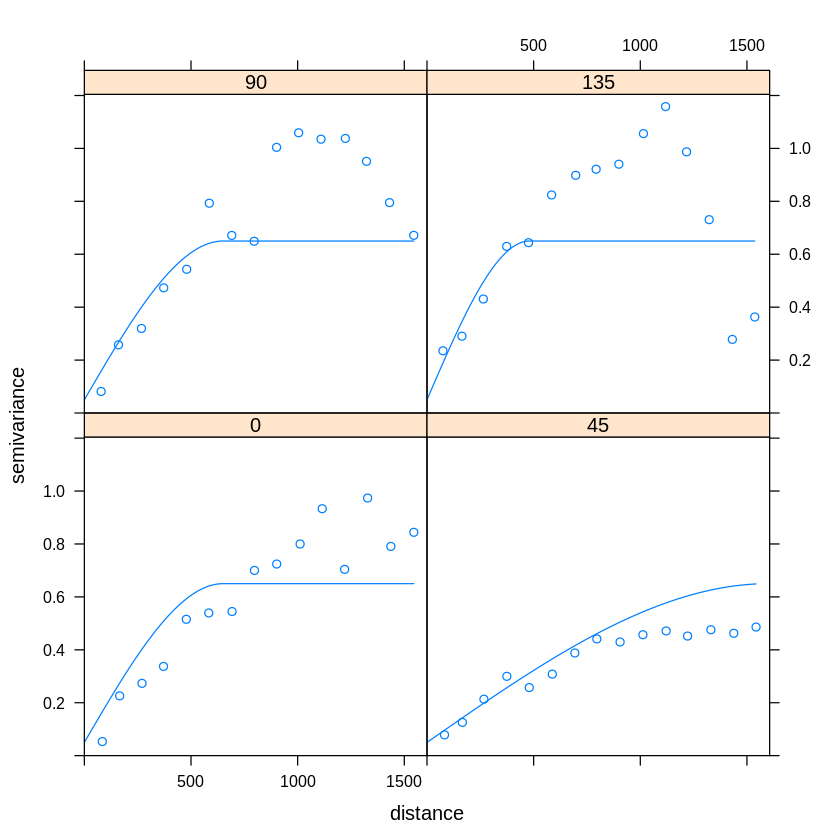

In [13]:
v.dir <- variogram(log(zinc) ~ 1, meuse, alpha = (0:3) * 45)
v.anis <- vgm(0.6, "Sph", 1600, 0.05, anis = c(45, 0.3))
plot(v.dir, v.anis)

* When more measurement information is available, one may consider plotting a *variaogram map*

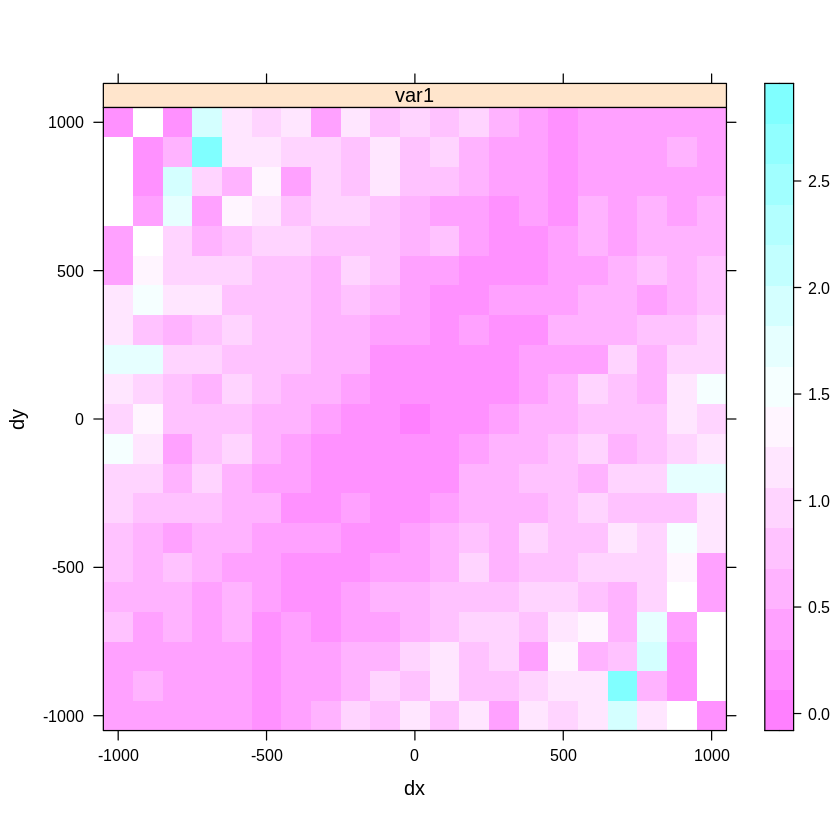

In [15]:
plot(variogram(log(zinc) ~ 1, meuse, map = TRUE, cutoff = 1000, width = 100))

## Multivariable Variogram Modelling

When we have multiple dependent spatial variables and are interested in analysing them jointly we called it multivariable variogram. 

To estimate semivariances between different variables across variograns:
<p>&nbsp;</p>

\begin{split}
γ_{ij}(h) & = E[(Z_i{(s)}-Z_i(s + h))(Z_j{(s)}-Z_j(s + h)) ] \\
\end{split}




In [17]:
# First let'w store available information in a variable g
g <-gstat(NULL, "logCd", log(cadmium) ~ 1, meuse)
g <- gstat(g, "logCu", log(copper) ~ 1, meuse)
g <- gstat(g, "logPb", log(lead) ~ 1, meuse)
g <- gstat(g, "logZn", log(zinc) ~ 1, meuse)
g

data:
logCd : formula = log(cadmium)`~`1 ; data dim = 155 x 12
logCu : formula = log(copper)`~`1 ; data dim = 155 x 12
logPb : formula = log(lead)`~`1 ; data dim = 155 x 12
logZn : formula = log(zinc)`~`1 ; data dim = 155 x 12

* The function **fit.lmc** fits a linear model of co-regionalization. 

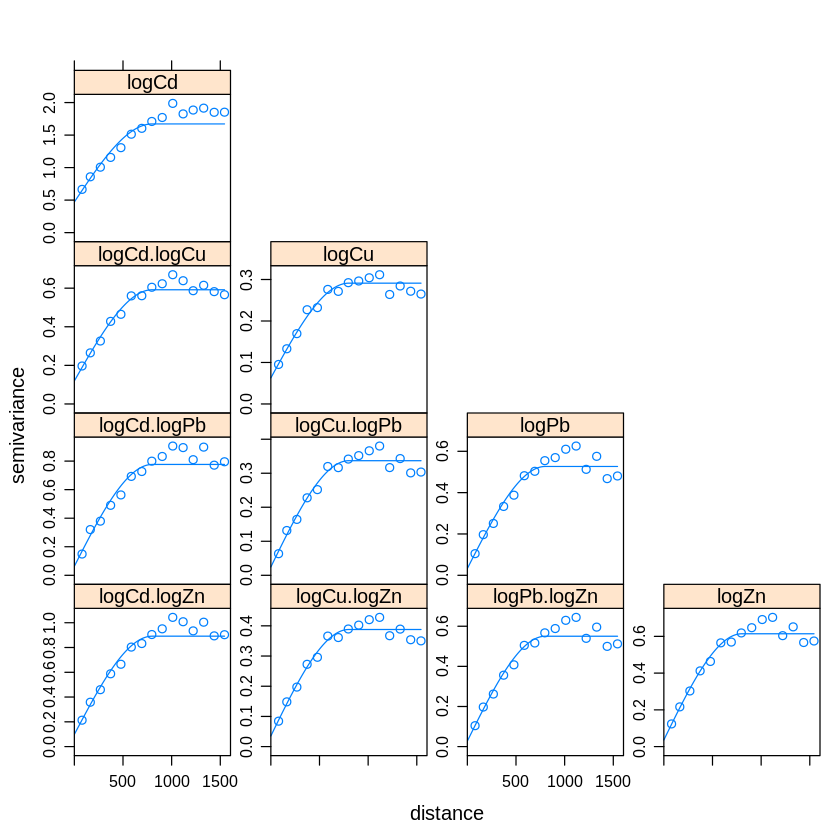

In [20]:
vm <- variogram(g)
vm.fit <- fit.lmc(vm, g, vgm(1, "Sph", 800, 1))
plot(vm, vm.fit)

* The variables have a strong cross correlation.

In [21]:
cor(as.data.frame(meuse)[c("cadmium", "copper", "lead", "zinc")])

,cadmium,copper,lead,zinc
cadmium,1.0000000,0.9254499,0.7989466,0.9162139
copper,0.9254499,1.0000000,0.8183069,0.9082695
lead,0.7989466,0.8183069,1.0000000,0.9546913
zinc,0.9162139,0.9082695,0.9546913,1.0000000


## Residual Variogram Modelling

Residual variogram are calculated by default when a more complex model for the trend is used:


\begin{split}
log(Z{(s)}) & = β_0 + \sqrt{D(S)}β_1 + e(s)\\
\end{split}
<p>&nbsp;</p>

In [23]:
head(variogram(log(zinc) ~ sqrt(dist), meuse))

,np,dist,gamma,dir.hor,dir.ver,id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,57,79.29244,0.08819594,0,0,var1
2,299,163.97367,0.13523671,0,0,var1
3,419,267.36483,0.14718465,0,0,var1
4,457,372.73542,0.15929716,0,0,var1
5,547,478.47670,0.17933406,0,0,var1
6,533,585.34058,0.19298151,0,0,var1


* By default the residuals used are ordinary least squares residuals (i.e., regular regression residuals), which means that observation are considered independent. For the generalized least squares residuals:

In [6]:
f <- log(zinc) ~ sqrt(dist)
vt <- variogram(f, meuse)
vt.fit <- fit.variogram(vt, vgm(1, "Exp", 300, 1))
vt.fit[,1:3]

,model,psill,range
,<fct>,<dbl>,<dbl>
1,Nug,0.05712231,0.0000
2,Exp,0.17641559,340.3201


In [30]:
g.wls <- gstat(NULL, "log-zinc", f, meuse, model = vt.fit, set = list(gls = 1))
(variogram(g.wls)$gamma - vt$gamma)/mean(vt$gamma)

[1]  1.133887e-05 -6.800894e-05 -1.588582e-04 -2.520913e-04 -5.461007e-05
 [6] -1.257573e-04  2.560629e-04  1.509185e-04  4.812184e-07 -5.292472e-05
[11] -2.998868e-04  2.169712e-04 -1.771773e-04  1.872195e-04  3.095021e-05

## Spatial Prediction

Predict unknown quantities $Z(s0)$, based on sample data $Z(si)$ and the assumption regarding the trend of $Z$ and its variance and spatial correlation. 

\begin{split}
\hat Z(s_0)  = x(s_0) β + v'V^{-1}(Z(s) - Xβ)
\end{split}
<p>&nbsp;</p>

in which the generalized least square estimate of the trend is:

\begin{split}
\hat β  = (X'V^{-1}X)^{-1} X'V^{-1}Z(s)
\end{split}
<p>&nbsp;</p>

The predictor consists of an estimated mean value for location $s0$, also known as the simple kringing weights.

## Universal, Ordinary, and Simple kringing

The differences in types of Kriging are in respect to how large scale trend is conceptualized:
   * Simple Kriging
          - Mean assumed constant and known
          - not a realistic model 
   \begin{split} Z(s) = μ + e(s)\end{split}
          - Text book model but not practical
     <p>&nbsp;</p>
   * Ordinary Kriging
          - Mean is constant but must be estimated
          - Kriging part focuses on prediction of deviations from  unknown mean
    \begin{split} Z(s) = m + e(s)\end{split}
    <p>&nbsp;</p>
   * Universal Kriging or KED
          - Mean varies with location =  regression model
          - kriging focuses on resisuals
              take into account undertainty from coefficient estimate
   \begin{split} Z(s) = x(s)b + e(s)\end{split}
          - many extension for different types of model
          - many technical issues
    <p>&nbsp;</p>

<img src="./Applied_Spatial_Analysis_with_R/KriggingDecision.png">


In [12]:
#Simple kriging: Trend coefficient is given
v <- variogram(log(zinc) ~ 1, meuse)
v.fit <- fit.variogram(v, vgm(1, "Sph", 800, 1))

lz.sk <- krige(log(zinc) ~ 1, meuse, meuse.grid, v.fit, beta = 5.9)

[using simple kriging]


In [13]:
# Ordinary kriging: Trend has only intercept "~1"
lz.ok <- krige(log(zinc) ~ 1, meuse, meuse.grid, v.fit)

[using ordinary kriging]


In [15]:
# Universal kriging: Trend has intercept "~1" and a second factor (dist)
lz.uk <- krige(log(zinc) ~ sqrt(dist), meuse, meuse.grid, vt.fit)

[using universal kriging]


## Multivariable Prediction: Cokriging

Kriging equations can be extended to multivariable prediction equations. The ideal is that the variables might be cross correlated and the spatial variability of one variable can be used to predict others. 

In [39]:
# First let'w store available information in a variable g
g <-gstat(NULL, "logCd", log(cadmium) ~ 1, meuse)
g <- gstat(g, "logCu", log(copper) ~ 1, meuse)
g <- gstat(g, "logPb", log(lead) ~ 1, meuse)
g <- gstat(g, "logZn", log(zinc) ~ 1, meuse)


vm <- variogram(g)
vm.fit <- fit.lmc(vm, g, vgm(1, "Sph", 800, 1))


cok.maps <- predict(vm.fit, meuse.grid)
names(cok.maps)


Linear Model of Coregionalization found. Good.
[using ordinary cokriging]


[1] "logCd.pred"      "logCd.var"       "logCu.pred"      "logCu.var"      
 [5] "logPb.pred"      "logPb.var"       "logZn.pred"      "logZn.var"      
 [9] "cov.logCd.logCu" "cov.logCd.logPb" "cov.logCu.logPb" "cov.logCd.logZn"
[13] "cov.logCu.logZn" "cov.logPb.logZn"

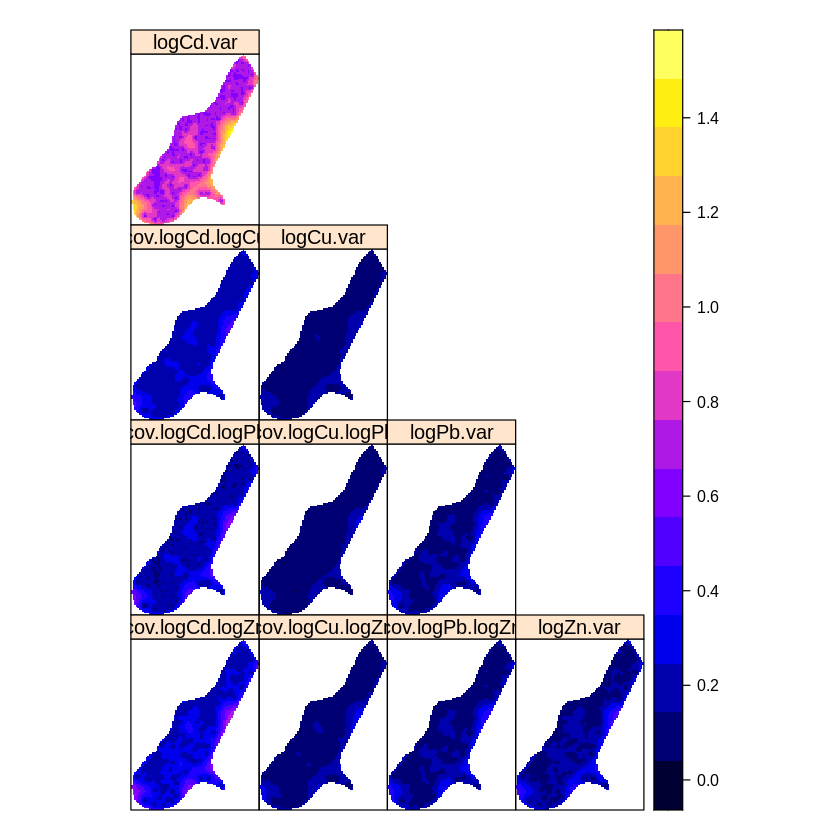

In [27]:
spplot.vcov(cok.maps)

## Collocated cokriging

Collocated cokriging is a special case of cokriging, where a secondary variable is available at all prediction locations.



In [7]:
# Generate the variogram model
v <- variogram(log(zinc) ~ 1, meuse)
v.fit <- fit.variogram(v, vgm(1, "Sph", 800, 1))

# log(zinc) as primary variable
g.cc <- gstat(NULL, "log.zinc", log(zinc) ~ 1, meuse, model = v.fit)
meuse.grid$distn <- meuse.grid$dist - mean(meuse.grid$dist) + mean(log(meuse$zinc))

vd.fit <- v.fit
vov <- var(meuse.grid$distn)/var(log(meuse$zinc))
vd.fit$psill <- v.fit$psill * vov

# dist as secondary variable
g.cc <- gstat(g.cc, "distn", distn ~ 1, meuse.grid, nmax = 1, model = vd.fit, merge = c("log.zinc", "distn"))
vx.fit <- v.fit
vx.fit$psill <- sqrt(v.fit$psill * vd.fit$psill) * cor(meuse$dist, log(meuse$zinc))


g.cc <- gstat(g.cc, c("log.zinc", "distn"), model = vx.fit)

x <- predict(g.cc, meuse.grid)
names(x)

Linear Model of Coregionalization found. Good.
[using ordinary cokriging]


[1] "log.zinc.pred"      "log.zinc.var"       "distn.pred"        
[4] "distn.var"          "cov.log.zinc.distn"

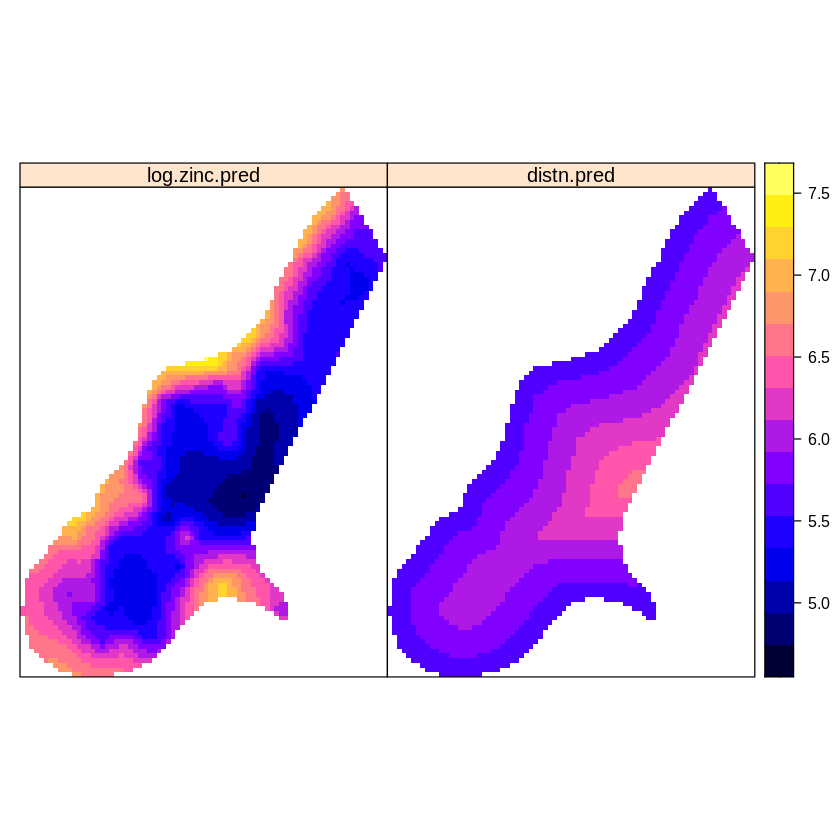

In [38]:
spplot(x, c('log.zinc.pred', 'distn.pred'))

## Cokriging Contrasts

The function **get.contr** computes the expectation value and error variabce for any linear combination (contrast) in a set of predictors, obtained by cokriging

In [40]:
#demo(pcb)

## Kriging in a Local Neighbourhood

By default, **gstat** uses all available observation for each prediction. However, in many cases it is more convenient to use only data in the neighbourhood for the prediction location for statistical or computational reasons.

Neighbourhoods in **gstat** are defined by passing the arguments **nmax**, **nmin**, and **maxdist** to functions like **predict**, **krige** or **gstat**


## Change of Support: Block Kriging




## Stratifying the Domain

When a cateforical variable is available that splits the are of interest in a number of disjust areas, for example based on geology, soil type, land use of some other factor, we might wan to apply separate kriging to the different units. This is called stratified kriging.
The covariance structure (semivariogram) might be different at the different classes.

[inverse distance weighted interpolation]
[using ordinary kriging]
[using ordinary kriging]


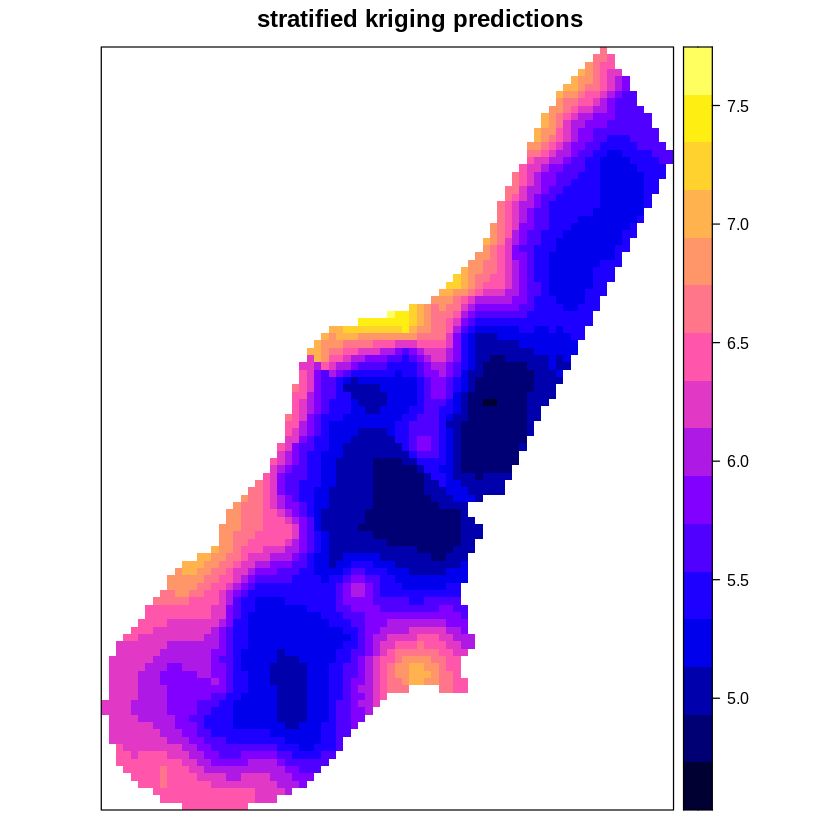

In [8]:
# Variable part.a will divide the total area in two: 0, 1.
meuse$part.a <- idw(part.a ~ 1, meuse.grid, meuse, nmax = 1)$var1.pred

# Kriging on the first area 0
x1 <- krige(log(zinc) ~ 1, meuse[meuse$part.a == 0, ], meuse.grid[meuse.grid$part.a == 0, ], model = vgm(0.548, "Sph", 900, 0.0654), nmin = 20, nmax = 40, maxdist = 1000)
# Kriging on the second area 1
x2 <- krige(log(zinc) ~ 1, meuse[meuse$part.a == 1, ], meuse.grid[meuse.grid$part.a == 1, ], model = vgm(0.716, "Sph", 900), nmin = 20, nmax = 40, maxdist = 1000)

# Combaning data again
lz.stk <- rbind(as.data.frame(x1), as.data.frame(x2))
coordinates(lz.stk) <- c("x", "y")
lz.stk <- as(lz.stk, "SpatialPixelsDataFrame")
spplot(lz.stk["var1.pred"], main = "stratified kriging predictions")

## Trend Functions and their Coefficients

Some times it useful to limit the range of values for specific paramters. The two main cases where that could be useful is in exploratory data analysis and regression diagnostics. To accomplish this, we must change the argument **BLUE = TRUE**




In [10]:
# Universal Kriging
g.tr <- gstat(formula = log(zinc) ~ sqrt(dist), data = meuse, model = v.fit)
predict(g.tr, meuse[1, ])

# Trend estimation
predict(g.tr, meuse[1, ], BLUE = TRUE)

[using universal kriging]


       coordinates var1.pred     var1.var
1 (181072, 333611)  6.929517 2.484317e-33

[generalized least squares trend estimation]


       coordinates var1.pred   var1.var
1 (181072, 333611)  6.862085 0.06123864

In [13]:
#predict(g.tr, meuse[1, ], BLUE = TRUE, debug = 32)

## Non-Linear Transforms of the Response Variable

A non-linear transformation for predictor variables. The use of a good transformation, such as using **sqrt(dist)** instead of **dist**, may help us in approaching the problem fitting the relationship between variables with a strainght line. 

That is not so straightfoward for the de dependent variable. That means that if we compute kriging for predictors for zince on the log scale, we do not obtain the expected zinc concentration by taking the exponent of the kriging predictor.

Conditional transformation such as the one's performed by the Box-Cox family can ilustrate that:

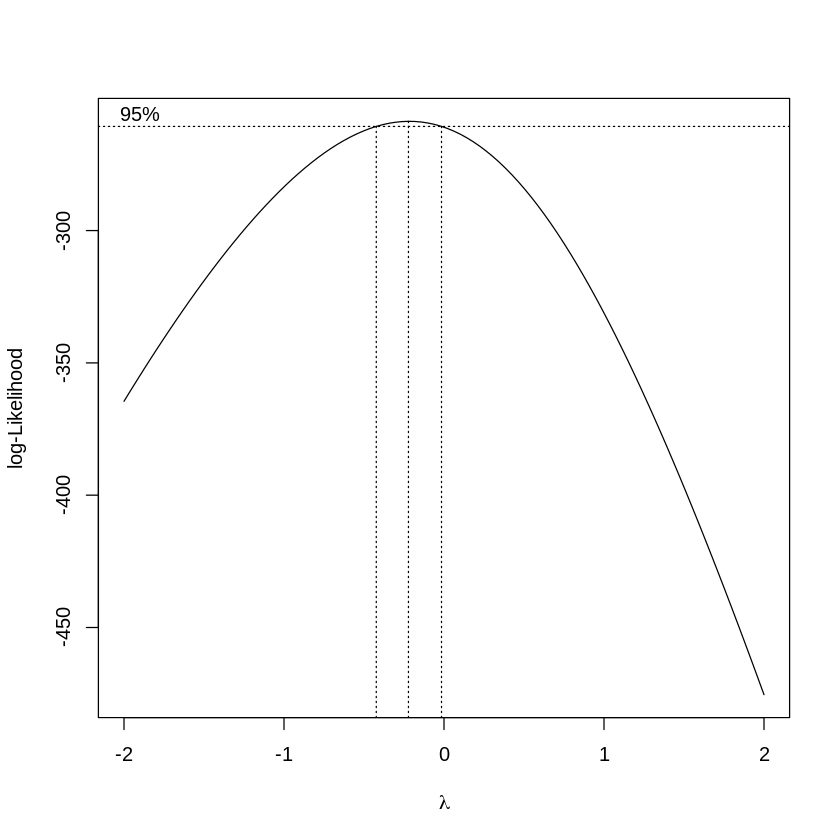

In [9]:
library(MASS)

# ML profile plot for lambda
boxcox(zinc ~ sqrt(dist), data = as.data.frame(meuse))

## Singular Matrix Errors

Kriging cannot deal with duplicate observations or observations that share the same location, because they are perfectly correlated and lead to singular covariance matrices $V$, meaning that $V^{-1}v$ has no unique solution. 

Most common cases when that happens is when duplicate observations are present in the data set.

In [15]:
meuse.dup <- rbind(as.data.frame(meuse)[1, ], as.data.frame(meuse))
coordinates(meuse.dup) = ~x + y
krige(log(zinc) ~ 1, meuse.dup, meuse[1, ], v.fit)


# Duplications can be found with the zerodist function
zd <- zerodist(meuse.dup)
zd

[using ordinary kriging]


Warning message in predict.gstat(g, newdata = newdata, block = block, nsim = nsim, :
“Covariance matrix singular at location [181072,333611,0]: skipping...”


       coordinates var1.pred var1.var
1 (181072, 333611)        NA       NA

1,2


In [16]:
# the following command removes duplicated
krige(log(zinc) ~ 1, meuse.dup[-zd[, 1], ], meuse[1,], v.fit)

[using ordinary kriging]


       coordinates var1.pred     var1.var
1 (181072, 333611)  6.929517 1.963167e-33

## Model Diagnostics

To this point we have seen a large number of possible model decision can be made:
  
  * Transformation of the dependent variable
  * The form of the trend function
  * Cutoff, lag width, directional dependence for the sample variogram
  * Variogram model types
  * Variogram model coefficient values or fitting method
  * Size and criterion to define a local neighbourhood

Cross validation can help us make decision about the parameter choices.

### Cross Validation Residuals

CV splits the data into two sets: a modelling set and a validation set. The modelling set is used for variogram modelling and kriging on the locations of the validation set, and then the validation measurements can be compared to their predictions. If we have a good predicting model, cross validation residuals are small, have zero mean and no apparent structure.

The samples are often randomly assigned to test or validation set at different proportions. Here, 100 samples will be used for the modelling and 55 will be used for the testing. 

In [28]:
set.seed(13331)

# Subsetting variables to be used in the modelling
sel100 <- sample(1:155, 100)

m.model <- meuse[sel100, ]
m.valid <- meuse[-sel100, ]


v100.fit <- fit.variogram(variogram(log(zinc) ~ 1, m.model), vgm(1, "Sph", 800, 1))
m.valid.pr <- krige(log(zinc) ~ 1, m.model, m.valid, v100.fit)


resid.kr <- log(m.valid$zinc) - m.valid.pr$var1.pred
summary(resid.kr)

[using ordinary kriging]


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.823843 -0.245760 -0.077000 -0.001749  0.285735  1.209053 

In [29]:
resid.mean <- log(m.valid$zinc) - mean(log(m.valid$zinc))
R2 <- 1 - sum(resid.kr^2)/sum(resid.mean^2)
R2

[1] 0.6773846

*  indicates that kriging prediction is a better predictor than the mean with an R2 of ~0.68.

* Variograms are not fitted every fold interaction, but once with the whole data.

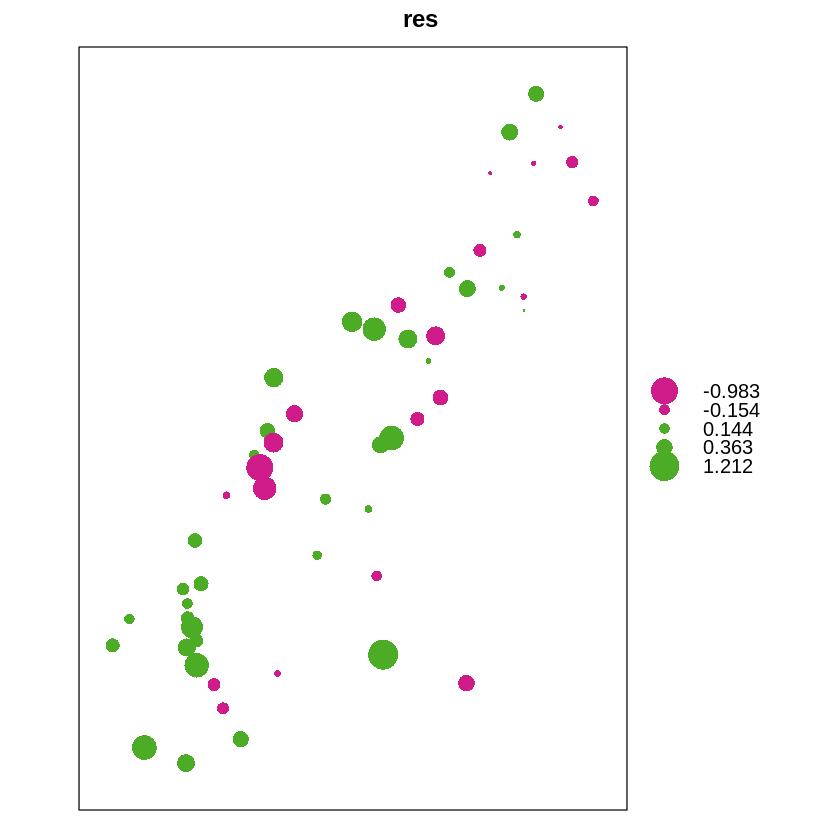

In [23]:
# A map with the residuals can also be generated
# The symbols denote proportion to the absolute value
m.valid.pr$res <- resid.kr
bubble(m.valid.pr, "res")

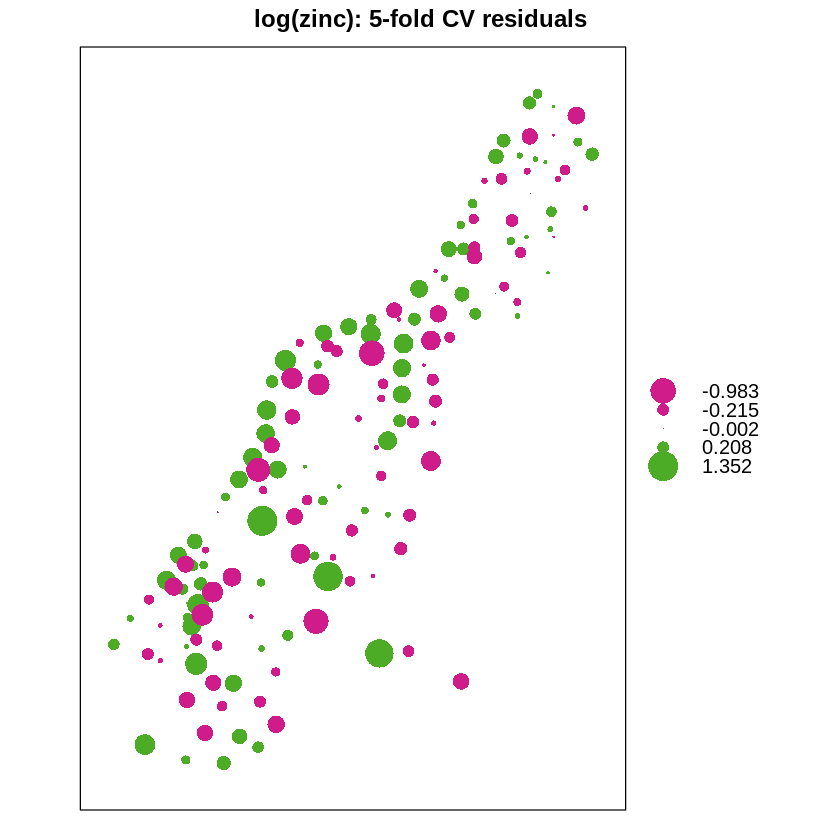

In [24]:
#Now using the full data using 5-fold CV
v.fit <- vgm(0.59, "Sph", 874, 0.04)
cv155 <- krige.cv(log(zinc) ~ 1, meuse, v.fit, nfold = 5)

bubble(cv155, "residual", main = "log(zinc): 5-fold CV residuals")

## Cross Validation z-Scores

inspecting the residuals alone:

In [25]:
summary(cv155)

Object of class SpatialPointsDataFrame
Coordinates:
     min    max
x 178605 181390
y 329714 333611
Is projected: NA 
proj4string : [NA]
Number of points: 155
Data attributes:
   var1.pred        var1.var         observed        residual        
 Min.   :4.787   Min.   :0.1040   Min.   :4.727   Min.   :-0.982630  
 1st Qu.:5.372   1st Qu.:0.1513   1st Qu.:5.288   1st Qu.:-0.215307  
 Median :5.846   Median :0.1776   Median :5.787   Median :-0.001604  
 Mean   :5.871   Mean   :0.1877   Mean   :5.886   Mean   : 0.015230  
 3rd Qu.:6.339   3rd Qu.:0.2015   3rd Qu.:6.514   3rd Qu.: 0.207907  
 Max.   :7.165   Max.   :0.5383   Max.   :7.517   Max.   : 1.352334  
     zscore               fold      
 Min.   :-2.379308   Min.   :1.000  
 1st Qu.:-0.487220   1st Qu.:2.000  
 Median :-0.003744   Median :3.000  
 Mean   : 0.032126   Mean   :2.968  
 3rd Qu.: 0.503436   3rd Qu.:4.000  
 Max.   : 2.955545   Max.   :5.000  

* Two variables were includes, **fold** indicating which fold each sample belong, and the variable **z-score** computed as the following:

<p>&nbsp;</p>
\begin{split}
z_i & = \frac{Z{(s_i)}- \hat Z_{[i]}(s_i)}{σ_{[i]}(s_i)} \\
\end{split}
<p>&nbsp;</p>


$ \hat Z_{[i]}(s_i) $ is the CV prection for $si$ and $σ_{[i]}(s_i)$ is the corresponding kriging standard error.

## Limitations to Cross Validation

It can be used to spot artefacts in data, but should be implemented carefully if the purpose is confirmatory. That can be a problem particular for comparison of models that are testing ranges not well coved be the samples.

In [31]:
# Adding data at only distances smaller than 40m
v1.fit <- vgm(0.591, "Sph", 897, 0.0507)
v2.fit <- vgm(0.591, "Sph", 897, add.to = vgm(0.0507, "Sph", 40))

In [33]:
set.seed(13331)
cv155.1 <- krige.cv(log(zinc) ~ 1, meuse, v1.fit, nfold = 5)
set.seed(13331)
cv155.2 <- krige.cv(log(zinc) ~ 1, meuse, v2.fit, nfold = 5)

# CV results wrongly concludes that there is no difference between the two models
summary(cv155.1$residual - cv155.2$residual)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0       0       0       0 

In [34]:
b1 <- krige(log(zinc) ~ 1, meuse, meuse.grid, v1.fit, block = c(40, 40))$var1.var
b2 <- krige(log(zinc) ~ 1, meuse, meuse.grid, v2.fit, block = c(40, 40))$var1.var

# Block kriging show large difference between the two models
summary((b1 - b2)/b1)

[using ordinary kriging]
[using ordinary kriging]


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.4313 -0.2195 -0.1684 -0.1584 -0.1071  0.4374 

## Geostatistical Simulation

* Geostatistical simulations refers to the simulation of possible realizations of a random field, given the specifications for that random field (mean structure, residual variogram, intrinsic stationarity) and possible observation data.

* Conditional simulations produces realizations that exactly honour observed data at data locations, unconditional simulations ignore observations and only reproduce means and prescribed variability

### Sequential Simulation

Sequential simulation proceeds as follows:

1. Compute the conditional distribution given data and previously simulates values, using kriging
2. Draw a value from this conditional distribution
3. Add this value to the data set
4. Go to the next unvisited location, and go back to 1

* To obtain simulations with a reasonable speed, we need to set a maximum to the neighbourhood using the nmax argument.

drawing 6 GLS realisations of beta...
[using conditional Gaussian simulation]


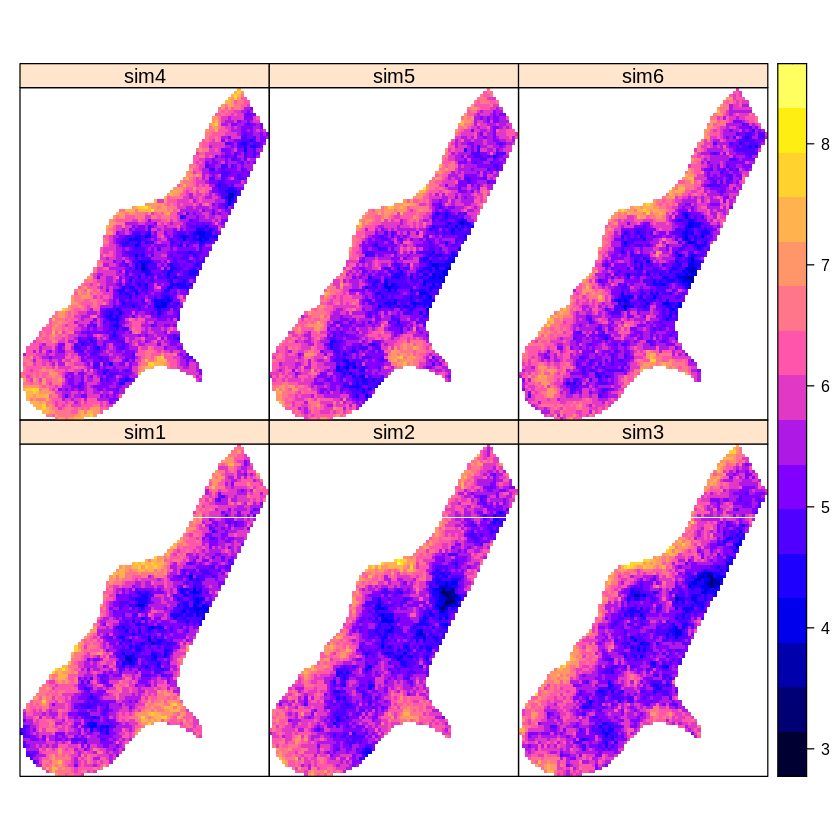

In [35]:
# Generating 6 realizations of beta with nmax of 40
lzn.sim <- krige(log(zinc) ~ 1, meuse, meuse.grid, v.fit, nsim = 6, nmax = 40)

spplot(lzn.sim)

## Multivariable and Indicator Simulation




In [44]:
vm <- variogram(g)
vm.fit <- fit.lmc(vm, g, vgm(1, "Sph", 800, 1))



out = gstat.cv(vm.fit, nmax = 40, nfold = 5)
summary(out)
#out = gstat.cv(meuse.fit, nmax = 40, nfold = c(rep(1,100), rep(2,55)))


# Multivariable simulation 
cok.sims <- predict(out, meuse.grid, nsim = 1000)

Linear Model of Coregionalization found. Good.
[using ordinary cokriging]
Linear Model of Coregionalization found. Good.
[using ordinary cokriging]
Linear Model of Coregionalization found. Good.
[using ordinary cokriging]
Linear Model of Coregionalization found. Good.
[using ordinary cokriging]
Linear Model of Coregionalization found. Good.
[using ordinary cokriging]


Object of class SpatialPointsDataFrame
Coordinates:
     min    max
x 178605 181390
y 329714 333611
Is projected: NA 
proj4string : [NA]
Number of points: 155
Data attributes:
   logCd.pred        logCd.var         observed          residual        
 Min.   :-1.5296   Min.   :0.2362   Min.   :-1.6094   Min.   :-1.623601  
 1st Qu.:-0.2909   1st Qu.:0.2567   1st Qu.:-0.2231   1st Qu.:-0.223796  
 Median : 0.5131   Median :0.2649   Median : 0.7419   Median : 0.056980  
 Mean   : 0.5589   Mean   :0.2679   Mean   : 0.5611   Mean   : 0.002158  
 3rd Qu.: 1.4261   3rd Qu.:0.2762   3rd Qu.: 1.3480   3rd Qu.: 0.308677  
 Max.   : 2.9704   Max.   :0.3500   Max.   : 2.8959   Max.   : 1.172915  
     zscore               fold      
 Min.   :-3.181481   Min.   :1.000  
 1st Qu.:-0.427627   1st Qu.:2.000  
 Median : 0.113097   Median :3.000  
 Mean   : 0.005661   Mean   :3.084  
 3rd Qu.: 0.598179   3rd Qu.:4.000  
 Max.   : 2.268111   Max.   :5.000  

ERROR: Error in UseMethod("predict"): no applicable method for 'predict' applied to an object of class "c('SpatialPointsDataFrame', 'SpatialPoints', 'Spatial', 'SpatialPointsNULL')"


In [45]:
# Table with soil classes
table(meuse$soil)


 1  2  3 
97 46 12 

In [46]:
# Realization with soil class 1
s1.fit <- fit.variogram(variogram(I(soil == 1) ~ 1, meuse), vgm(1, "Sph", 800, 1))
s1.sim <- krige(I(soil == 1) ~ 1, meuse, meuse.grid, s1.fit, nsim = 6, indicators = TRUE, nmax = 40)

drawing 6 GLS realisations of beta...
[using conditional indicator simulation]


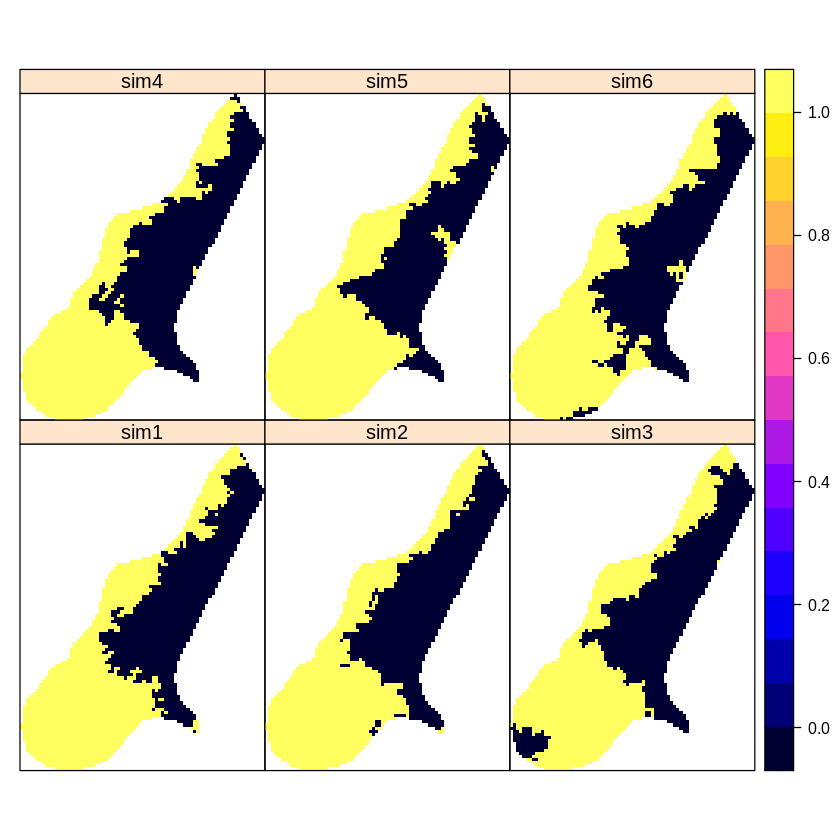

In [47]:
# 6 realizations of conditional indicator simulation for soil type 1
spplot(s1.sim)

## Model-Based Geostatistics and Bayesian Approaches

model-based geostatistical predictions based on inear mixed and generalized linear mixed models. When to use:
   * when the sample is small
   * when variogram modelling is problematic
due to the presence of extreme observations or data that come from a strongly skewed distribution

## Monitoring Network Optimization


Monitoring programs have to:
1. be designed
2. started,
3. stopped
4. evaluated
5. sometimes need to be enlarged or shrunken

* The difficulty of finding optimal network designs is that a quantitative criterion is often a priori not present.

* A very simple approach towards monitoring network optimization is to find the point whose removal leads to the smallest increase in mean kriging variance:

In [48]:
m1 <- sapply(1:155, function(x) mean(krige(log(zinc) ~ 1, meuse[-x, ], meuse.grid, v.fit)$var1.var))

# which will point to observation 72 as the first candidate for removal
which(m1 == min(m1))

[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]


[1] 72

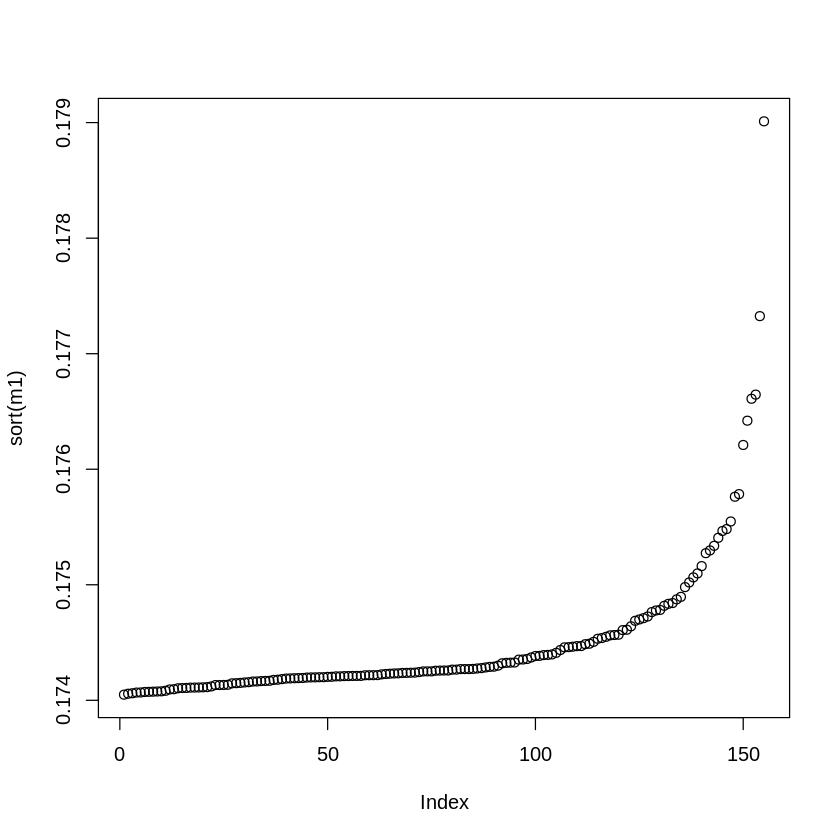

In [49]:
plot(sort(m1))

* Another approach would be to delineate contour for 500 ppm, for instance. The doubt can be expressed as if the location is below or above 500 ppm

<p>&nbsp;</p>
\begin{split}
G(\frac{\hat Z{(s_0)} - 500}{σ_(s_0)}) \\
\end{split}
<p>&nbsp;</p>

With $G(.)$ Gaussian distribution function


In [50]:

cutoff <- 1000
f <- function(x) { 
    kr = krige(log(zinc) ~ 1, meuse[-x, ], meuse.grid, v.fit)
    mean(abs(pnorm((kr$var1.pred - log(cutoff))/sqrt(kr$var1.var)) - 0.5))
}


m2 <- sapply(1:155, f)
which(m2 == max(m2))


[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]


[1] 82

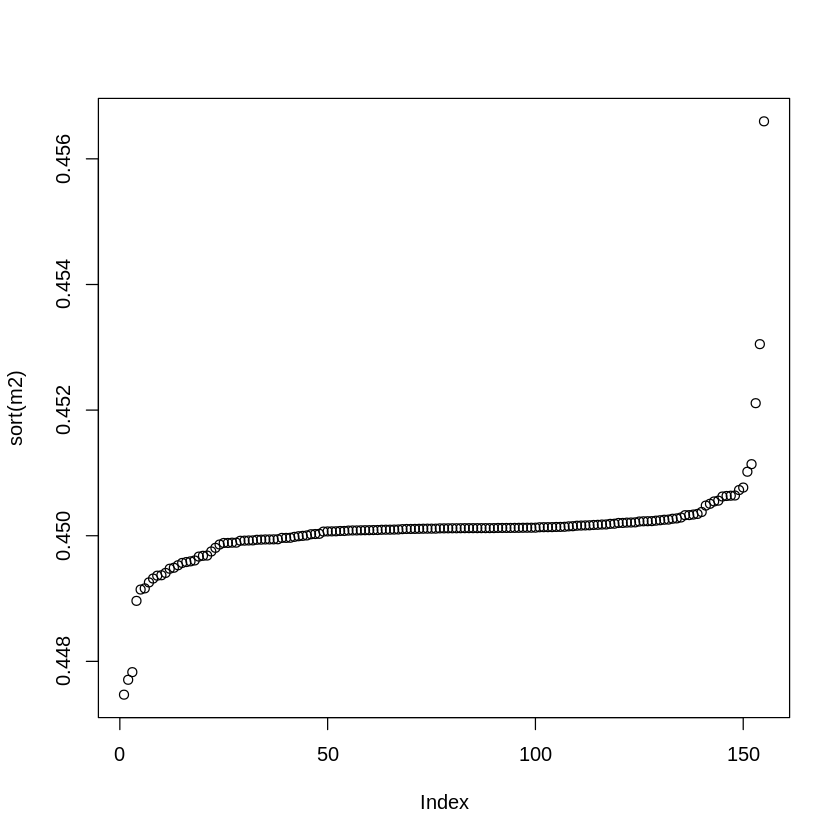

In [51]:
plot(sort(m2))